In [5]:
import os
import cv2
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading And Splitting

In [6]:
import pandas as pd
import os

# Improved function definition
def read_data_from_directory(path):
    filepaths = []
    labels = []

    # Check if the provided path exists
    if not os.path.isdir(path):
        raise ValueError(f"The provided path does not exist: {path}")

    # Use os.walk to traverse the directory structure
    for root, dirs, files in os.walk(path):
        # Skip the root directory itself and subdirectories (we only want files in the last directory)
        if root == path:
            continue

        # Extract label from the directory name
        label = os.path.basename(root)
        
        # Collect file paths and labels
        for file in files:
            filepath = os.path.join(root, file)
            filepaths.append(filepath)
            labels.append(label)
    
    # Create DataFrame
    data_df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})
    
    return data_df

# Load the dataset
data_df = read_data_from_directory(r'/kaggle/input/lung-colon-image-set')

# Display label counts
print(data_df['labels'].value_counts())

# Determine the number of classes
num_classes = len(data_df['labels'].unique())
print(f"Number of classes: {num_classes}")


labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64
Number of classes: 5


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and dummy (which will later be split into validation and test sets)
train_df, dummy = train_test_split(data_df, test_size=0.3, random_state=42, stratify=data_df['labels'])

# Split the dummy DataFrame into validation and test sets
val_df, test_df = train_test_split(dummy, test_size=0.5, random_state=42, stratify=dummy['labels'])

# Print the shapes of the resulting DataFrames
print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)


Training set shape: (17500, 2)
Validation set shape: (3750, 2)
Test set shape: (3750, 2)


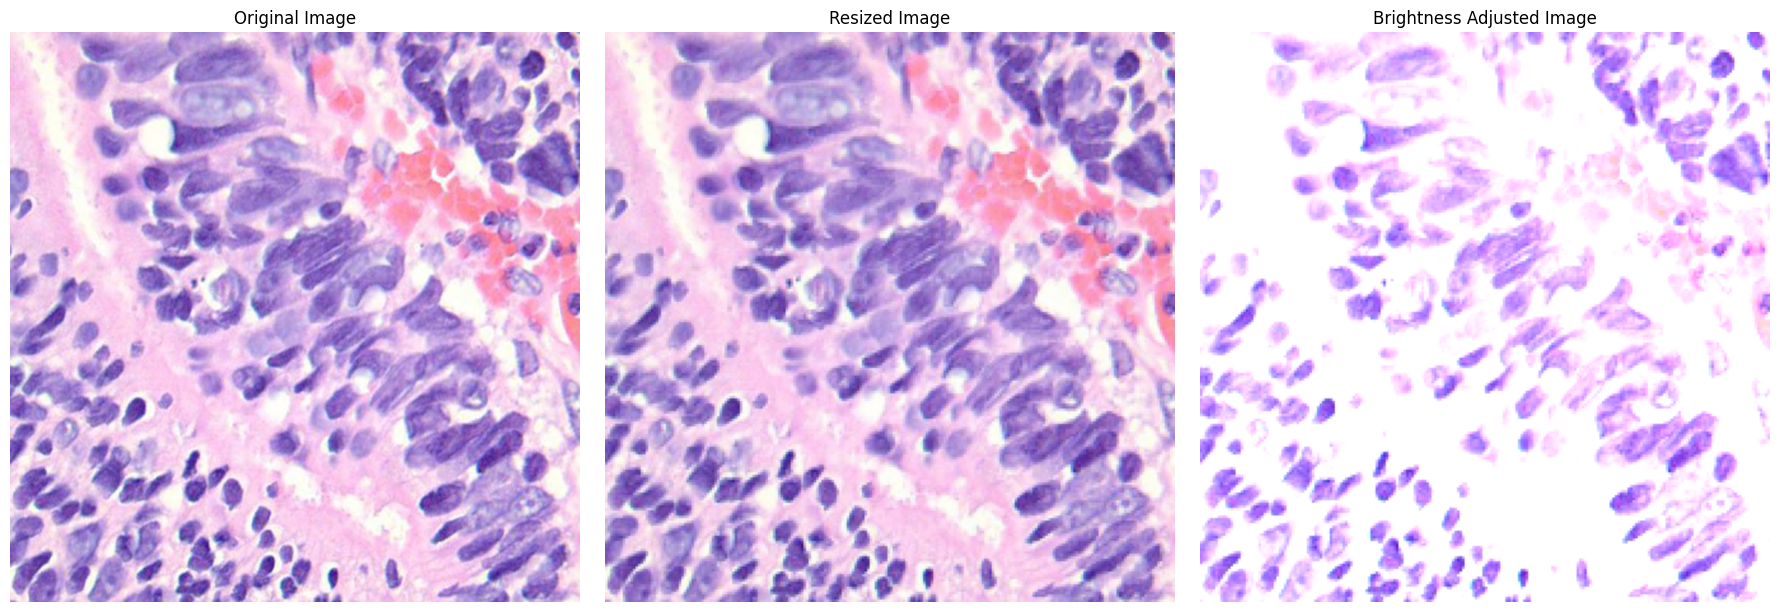

In [8]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# Function to load and preprocess a single image
def preprocess_image(image_path, target_size=(224, 224), brightness_factor=1.5):
    # Load the original image
    original_image = cv2.imread(image_path)
    
    # Check if the image is loaded correctly
    if original_image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Resize the image
    resized_image = cv2.resize(original_image, target_size)
    
    # Apply brightness adjustment
    adjusted_image = cv2.convertScaleAbs(resized_image, alpha=brightness_factor, beta=0)
    
    return original_image, resized_image, adjusted_image

# Example image path
image_path = train_df['file_paths'].iloc[0]

# Preprocess the image
original_image, resized_image, adjusted_image = preprocess_image(image_path)

# Display comparison of original, resized, and adjusted images
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Resized Image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized Image')
plt.axis('off')

# Brightness Adjusted Image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))
plt.title('Brightness Adjusted Image')
plt.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_30/795870040.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, i + 1)


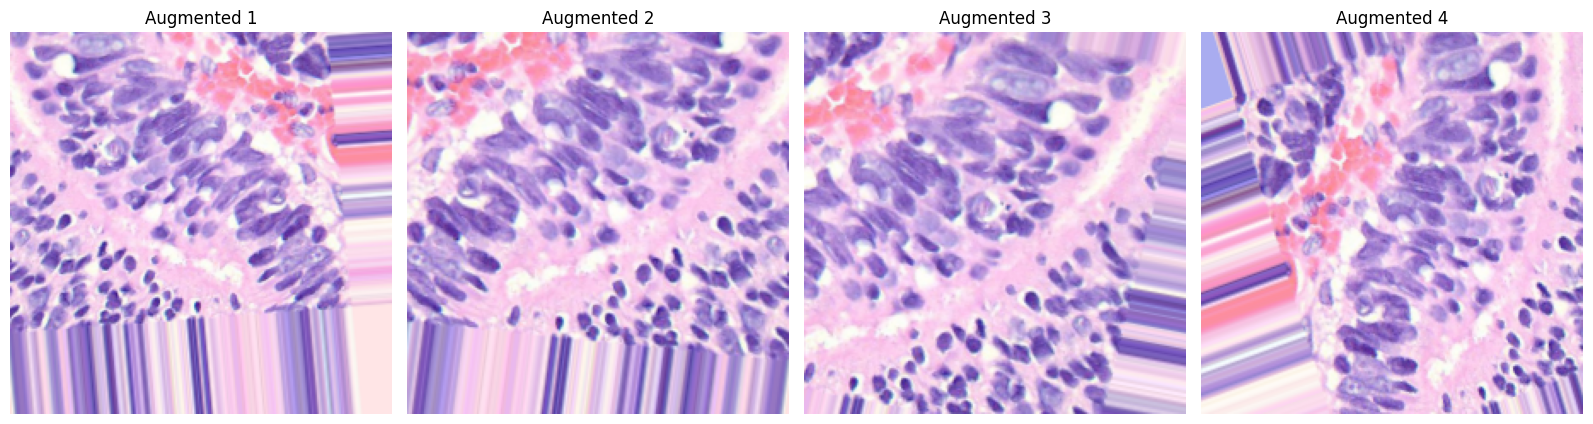

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_and_resize_image(image_path, target_size=(224, 224)):
    """Load an image from a path and resize it to the target size."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    resized_image = cv2.resize(image, target_size)
    return resized_image

def augment_image(image, datagen, num_augmented_images=4):
    """Generate and return augmented images using ImageDataGenerator."""
    # Expand dimensions to match the input shape required by ImageDataGenerator
    image_expanded = np.expand_dims(image, axis=0)
    
    # Create a generator for augmented images
    augmented_images = []
    for _ in range(num_augmented_images):
        augmented_image = next(datagen.flow(image_expanded, batch_size=1))[0]
        augmented_images.append(augmented_image.astype(np.uint8))
    
    return augmented_images

# Example image path
image_path = train_df['file_paths'].iloc[0]

# Load and preprocess the original image
resized_image = load_and_resize_image(image_path)

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = augment_image(resized_image, datagen, num_augmented_images=4)

# Display comparison of original and augmented images
plt.figure(figsize=(20, 6))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Augmented Images
for i, aug_image in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


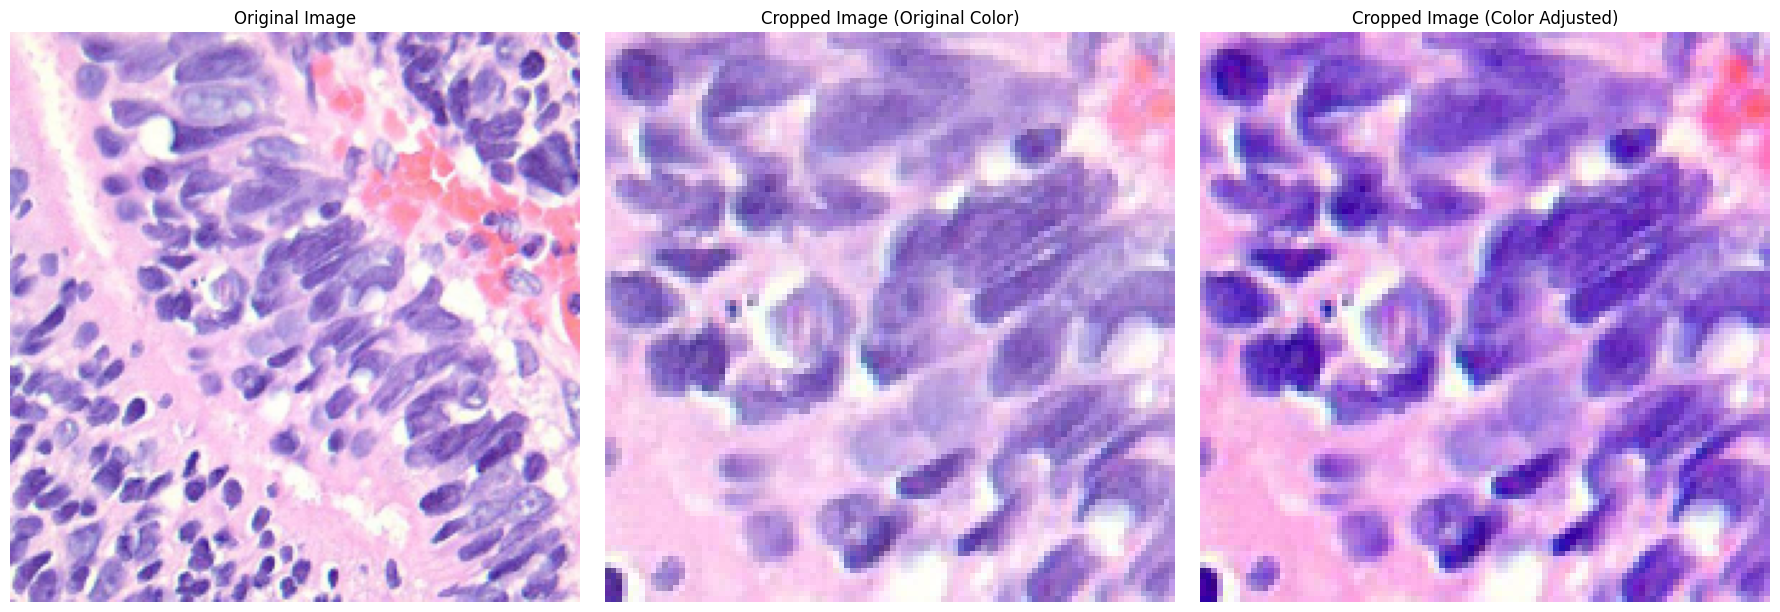

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_and_resize_image(image_path, target_size=(224, 224)):
    """Load and resize an image."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    return cv2.resize(image, target_size)

def crop_image(image, crop_area):
    """Crop an image based on the specified area."""
    x_start, y_start, x_end, y_end = crop_area
    return image[y_start:y_end, x_start:x_end]

def adjust_saturation(image, factor):
    """Increase the saturation of an image."""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * factor, 0, 255)  # Clip values to valid range
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

# Example image path (ensure this is correctly referencing 'file_paths')
image_path = train_df['file_paths'].iloc[0]

# Load and preprocess the original image
resized_image = load_and_resize_image(image_path)

# Crop the image
crop_area = (50, 50, 150, 150)  # Define crop area as (x_start, y_start, x_end, y_end)
cropped_image = crop_image(resized_image, crop_area)

# Apply color grading change (increase saturation)
cropped_image_colored = adjust_saturation(cropped_image, factor=1.5)

# Display comparison of original, cropped, and color-adjusted image
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Cropped Image (Original Color)
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image (Original Color)')
plt.axis('off')

# Cropped Image (Color Adjusted)
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cropped_image_colored, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image (Color Adjusted)')
plt.axis('off')

plt.tight_layout()
plt.show()


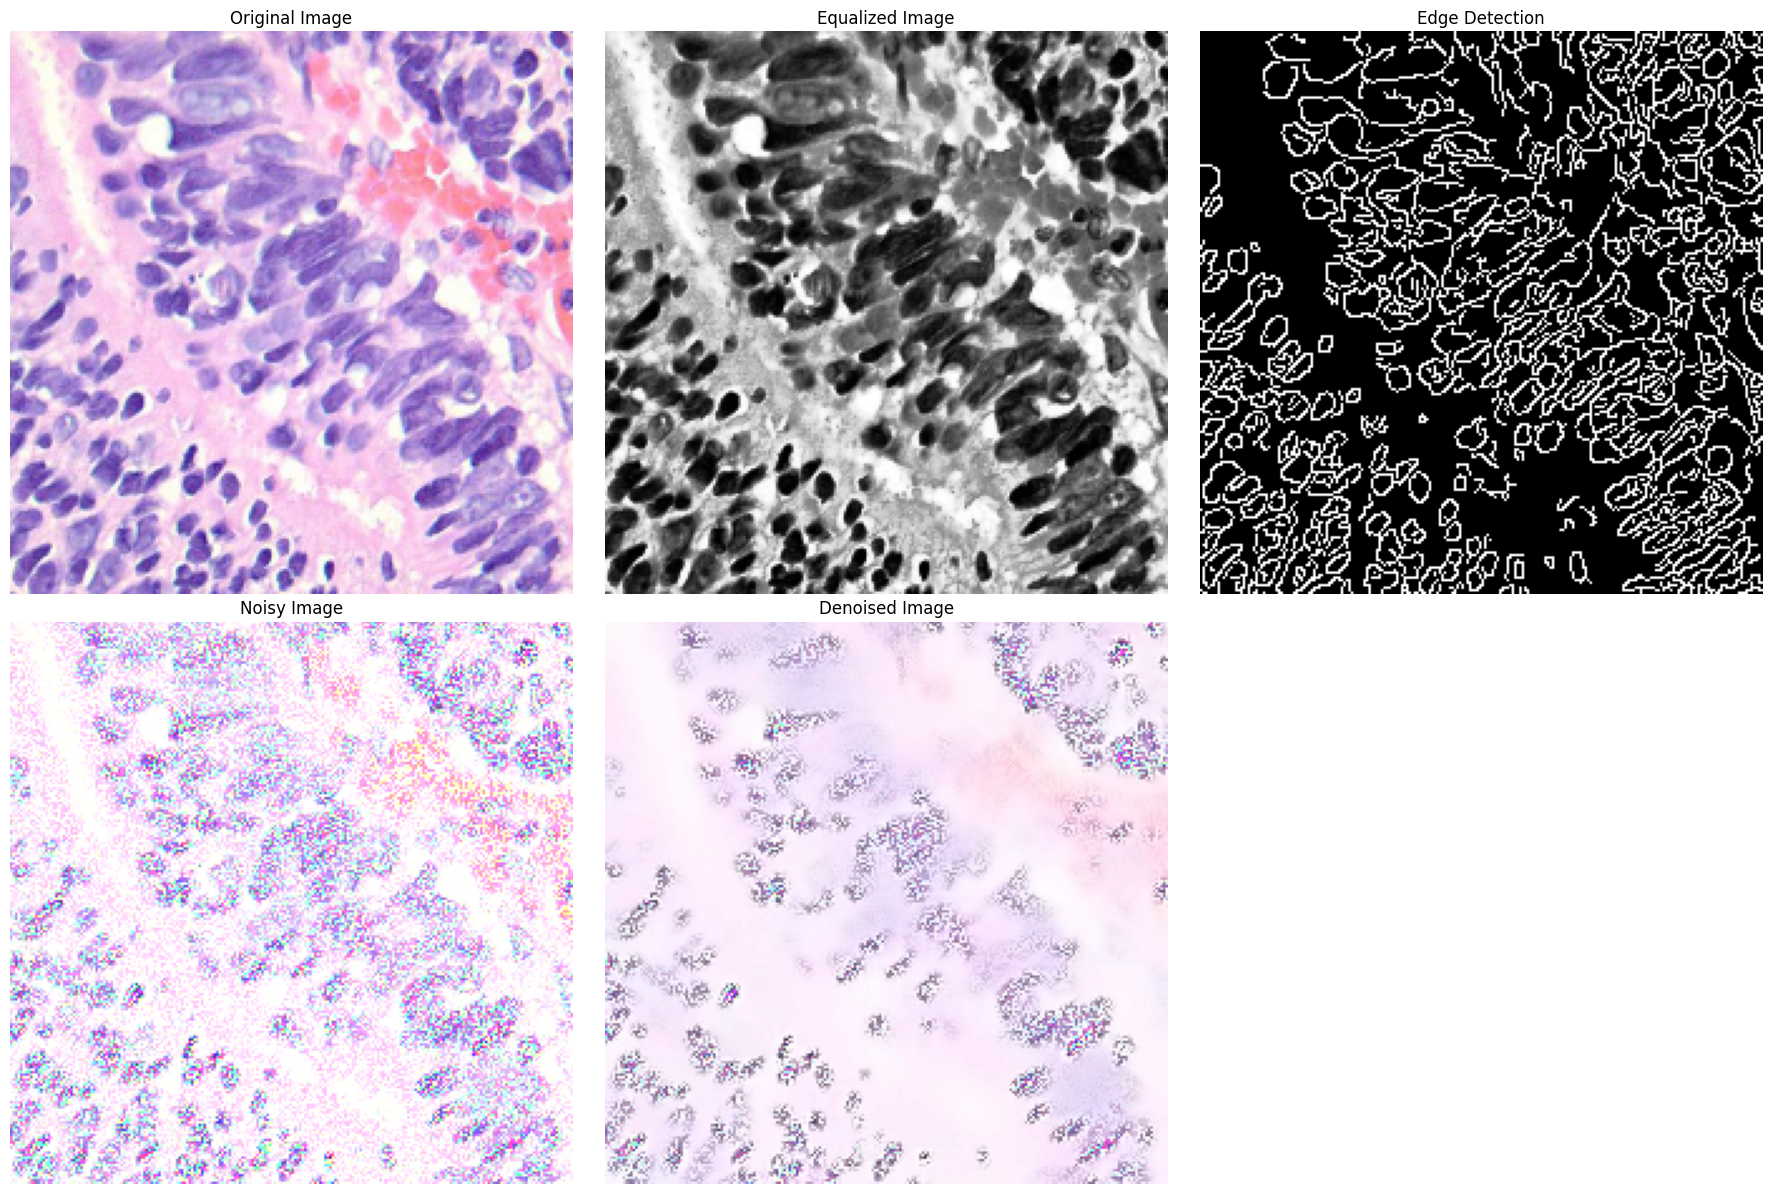

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_and_resize_image(image_path, target_size=(224, 224)):
    """Load and resize an image."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    return cv2.resize(image, target_size)

def apply_histogram_equalization(image):
    """Apply histogram equalization to a grayscale image."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.equalizeHist(gray_image)

def apply_edge_detection(image, lower_thresh=100, upper_thresh=200):
    """Apply edge detection using Canny algorithm."""
    return cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), lower_thresh, upper_thresh)

def add_noise(image, noise_std=25):
    """Add Gaussian noise to an image."""
    noise = np.random.normal(0, noise_std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def denoise_image(noisy_image, h=10, templateWindowSize=7, searchWindowSize=21):
    """Denoise an image using Non-Local Means Denoising."""
    return cv2.fastNlMeansDenoisingColored(noisy_image, None, h, h, templateWindowSize, searchWindowSize)

# Example image path (ensure this is correctly referencing 'file_paths')
image_path = train_df['file_paths'].iloc[0]

# Load and preprocess the original image
resized_image = load_and_resize_image(image_path)

# Apply histogram equalization
equalized_image = apply_histogram_equalization(resized_image)

# Apply edge detection
edges = apply_edge_detection(resized_image)

# Add noise and then denoise the image
noisy_image = add_noise(resized_image)
denoised_image = denoise_image(noisy_image)

# Display comparison of images
plt.figure(figsize=(18, 12))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Equalized Image
plt.subplot(2, 3, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# Edge Detection
plt.subplot(2, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

# Noisy Image
plt.subplot(2, 3, 4)
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.title('Noisy Image')
plt.axis('off')

# Denoised Image
plt.subplot(2, 3, 5)
plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
plt.title('Denoised Image')
plt.axis('off')

plt.tight_layout()
plt.show()


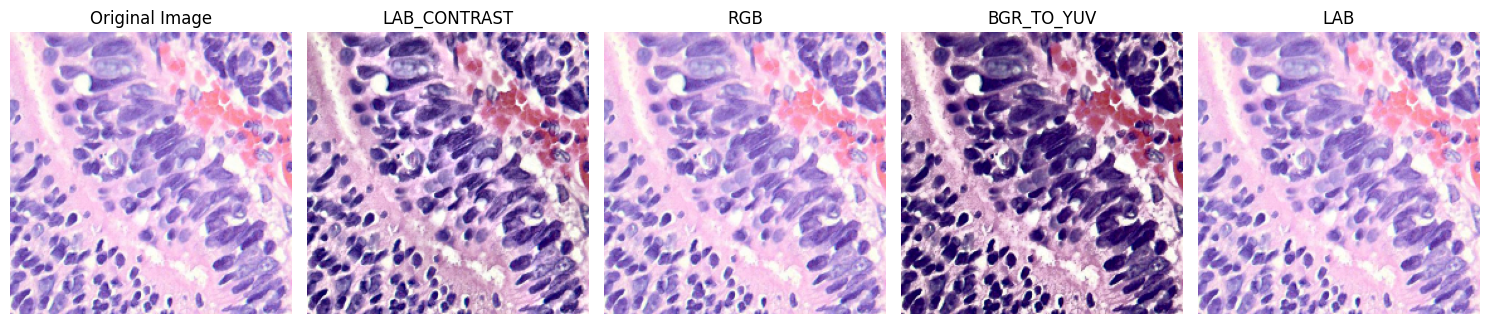

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess the image: resize and normalize."""
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)
    normalized_image = resized_image / 255.0  # Normalize to [0, 1] range
    return resized_image, normalized_image

def apply_color_transform(image, transform_type):
    """Apply different color transformations for model input optimization."""
    if transform_type == 'LAB_CONTRAST':
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        lab_image = cv2.merge([l_channel, a_channel, b_channel])
        return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    
    elif transform_type == 'RGB':
        # No transformation, just normalization
        return image
    
    elif transform_type == 'BGR_TO_YUV':
        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        y_channel, u_channel, v_channel = cv2.split(yuv_image)
        y_channel = cv2.equalizeHist(y_channel)  # Enhance luminance
        yuv_image = cv2.merge([y_channel, u_channel, v_channel])
        return cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)
    
    elif transform_type == 'LAB':
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    
    else:
        raise ValueError(f"Unsupported transformation type: {transform_type}")

def display_images(original, transformed_images, titles):
    """Display the original and transformed images for comparison."""
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(transformed_images) + 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    for i, (img, title) in enumerate(zip(transformed_images, titles), start=2):
        plt.subplot(1, len(transformed_images) + 1, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and preprocess the image
image_path = train_df['file_paths'].iloc[0]
resized_image, normalized_image = preprocess_image(image_path)

# Apply different color transformations
transformations = ['LAB_CONTRAST', 'RGB', 'BGR_TO_YUV', 'LAB']
transformed_images = [apply_color_transform(resized_image, t) for t in transformations]

# Display images
display_images(resized_image, transformed_images, transformations)


# Pre-Processing

In [13]:
from rich.progress import track
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

def apply_color_transform(image, transform_type):
    """Apply different color transformations for model input optimization."""
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    if transform_type == 'LAB_CONTRAST':
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel = clahe.apply(l_channel)
        lab_image = cv2.merge([l_channel, a_channel, b_channel])
        return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    
    elif transform_type == 'RGB':
        return image
    
    elif transform_type == 'BGR_TO_YUV':
        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        y_channel, u_channel, v_channel = cv2.split(yuv_image)
        y_channel = cv2.equalizeHist(y_channel)  # Enhance luminance
        yuv_image = cv2.merge([y_channel, u_channel, v_channel])
        return cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)
    
    elif transform_type == 'LAB':
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        return cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    
    elif transform_type == 'HISTOGRAM_EQUALIZATION':
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        equalized_image = cv2.equalizeHist(gray_image)
        return cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)  # Convert back to 3 channels

    elif transform_type == 'EDGE_DETECTION':
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_image, 100, 200)  # Apply edge detection with proper thresholds
        return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert edges to 3 channels

    elif transform_type == 'ADD_NOISE':
        noise_std = 25
        noise = np.random.normal(0, noise_std, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        return noisy_image
    
    elif transform_type == 'DENOISE':
        h, templateWindowSize, searchWindowSize = 10, 7, 21
        denoised_image = cv2.fastNlMeansDenoisingColored(image, None, h, h, templateWindowSize, searchWindowSize)
        return denoised_image

    else:
        raise ValueError(f"Unsupported transformation type: {transform_type}")


In [14]:
def preprocess_and_augment_data(df, target_size=(224, 224), transform_type='RGB', augment=True):
    """Preprocess, transform, and optionally augment the dataset."""
    X = []
    y = []
    
    for _, row in df.iterrows():
        image_path = row['file_paths']
        label = row['labels']
        
        # Load and preprocess the image
        _, normalized_image = preprocess_image(image_path, target_size)
        
        # Apply the specified color transformation
        transformed_image = apply_color_transform(normalized_image, transform_type)
        
        # Collect transformed images and labels
        X.append(transformed_image)
        y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = pd.factorize(y)[0]  # Convert labels to numerical format
    
    # Apply data augmentation if specified
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        # Apply augmentation to all images
        X_augmented = []
        y_augmented = []
        for img, label in zip(X, y):
            img = np.expand_dims(img, axis=0)
            for _ in range(4):  # Create 4 augmented images for each input image
                aug_img = datagen.flow(img, batch_size=1)[0].astype(np.uint8)
                X_augmented.append(aug_img[0])  # Append augmented image
                y_augmented.append(label)  # Append corresponding label
        
        X = np.array(X_augmented)
        y = np.array(y_augmented)
    
    return X, y

In [15]:
from rich.progress import track
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

def preprocess_and_augment_data_with_progress(df, target_size=(224, 224), transform_type=None, augment=False):
    X = []
    y = []

    # Initialize the progress bar using rich
    for index, row in enumerate(track(df.iterrows(), description="Processing images", total=len(df))):
        image_path = row[1]['file_paths']
        label = row[1]['labels']
        
        # Load and resize image
        resized_image = load_and_resize_image(image_path, target_size)

        # Normalize the image
        normalized_image = resized_image / 255.0

        # Apply the specified color transformation
        transformed_image = apply_color_transform(normalized_image, transform_type)

        # Optionally apply data augmentation
        if augment:
            augmented_images = augment_image(transformed_image, datagen, num_augmented_images=1)
            X.extend(augmented_images)
            y.extend([label] * len(augmented_images))
        else:
            X.append(transformed_image)
            y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Process training data
X_train, y_train = preprocess_and_augment_data_with_progress(
    train_df,
    target_size=(224, 224),
    transform_type='RGB',
    augment=True
)

# Process validation data
X_val, y_val = preprocess_and_augment_data_with_progress(
    val_df,
    target_size=(224, 224),
    transform_type='RGB',
    augment=False  # Typically, no augmentation for validation data
)

# Preprocess and optionally augment test data
X_test, y_test = preprocess_and_augment_data_with_progress(
    test_df,
    target_size=(224, 224),  # Match the target size used for training
    transform_type='RGB',  # Same transformation used for training
    augment=False  # Typically, we don't augment test data
)

# Verify and debug labels
print(f"Unique labels in y_train: {np.unique(y_train)}")
print(f"Unique labels in y_val: {np.unique(y_val)}")
print(f"Unique labels in y_test: {np.unique(y_test)}")

# Convert labels to integers
unique_labels = np.unique(y_train)
print(f"Unique labels before conversion: {unique_labels}")

label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print(f"Label mapping: {label_mapping}")

# Ensure all labels are in the label mapping
for label in np.unique(y_test):
    if label not in label_mapping:
        print(f"Label '{label}' not found in label mapping.")

y_train_int = np.array([label_mapping[label] for label in y_train])
y_val_int = np.array([label_mapping[label] for label in y_val])
y_test_int = np.array([label_mapping[label] for label in y_test])

# Convert labels to categorical
num_classes = len(unique_labels)
y_train_categorical = to_categorical(y_train_int, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_int, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_int, num_classes=num_classes)

# Verify the shape of the preprocessed and augmented data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train_categorical.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val_categorical.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test_categorical.shape)
print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)


Output()

Output()

Output()

Unique labels in y_train: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']
Unique labels in y_val: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']
Unique labels in y_test: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']
Unique labels before conversion: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']
Label mapping: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}
X_train shape: (17500, 224, 224, 3)
y_train shape: (17500, 5)
X_val shape: (3750, 224, 224, 3)
y_val shape: (3750, 5)
X_test shape: (3750, 224, 224, 3)
y_test shape: (3750, 5)
Training set shape: (17500, 2)
Validation set shape: (3750, 2)
Test set shape: (3750, 2)


# Customised Models

# 1. CNN Model

In [16]:
from tensorflow.keras import backend as K
K.clear_session()

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Define the input shape and other hyperparameters
input_shape = (224, 224, 3)  # Example input shape, adjust as needed
f1 = 16  # Number of filters in the first convolutional layer
f2 = 32  # Number of filters in the second convolutional layer
f3 = 32 # Number of filters in the third convolutional layer
f4 = 64 # Number of filters in the fourth convolutional layer
d1 = 32 # Number of units in the first dense layer
d2 = 64  # Number of units in the second dense layer
dropout_rate = 0.5  # Dropout rate
lr = 0.000100  # Learning rate
num_classes = 5  # Number of output classes, adjust as needed

# Define the model
CNN_model = Sequential([
    Input(shape=input_shape),  # Input layer
    
    # First convolutional block
    Conv2D(f1, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Second convolutional block
    Conv2D(f2, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Third convolutional block
    Conv2D(f3, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Fourth convolutional block
    Conv2D(f4, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Flatten and fully connected layers
    Flatten(),
    Dense(d1, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(dropout_rate),
    Dense(d2, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

# Compile the model
CNN_model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
CNN_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437,285 (1.67 MB)

 Trainable params: 436,997 (1.67 MB)

 Non-trainable params: 288 (1.12 KB)

In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.15, patience=3)

# Fit the model
history1 = CNN_model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=16),  # Reduced batch size
    epochs=10,
    validation_data=(X_val, y_val_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727382266.023897     114 service.cc:145] XLA service 0x7c89600058f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727382266.023961     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727382266.023967     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1094 ━━━━━━━━━━━━━━━━━━━━ 3:37:11 12s/step - accuracy: 0.3750 - loss: 1.9842

I0000 00:00:1727382273.437042     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 193s 166ms/step - accuracy: 0.4154 - loss: 1.3948 - val_accuracy: 0.6909 - val_loss: 0.8896 - learning_rate: 1.0000e-04
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 183s 166ms/step - accuracy: 0.5493 - loss: 1.0907 - val_accuracy: 0.6800 - val_loss: 0.7268 - learning_rate: 1.0000e-04
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 181s 164ms/step - accuracy: 0.5997 - loss: 0.9786 - val_accuracy: 0.6933 - val_loss: 0.6461 - learning_rate: 1.0000e-04
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 174s 158ms/step - accuracy: 0.6332 - loss: 0.8905 - val_accuracy: 0.7256 - val_loss: 0.5859 - learning_rate: 1.0000e-04
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 181s 164ms/step - accuracy: 0.6637 - loss: 0.8291 - val_accuracy: 0.7336 - val_loss: 0.5688 - learning_rate: 1.0000e-04
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 184s 167ms/step - accuracy: 0.6680 - loss: 0.7952 - val_accuracy: 0.7520 - val_loss: 0.5195 - learning_rate: 1.0000e-04
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━

In [20]:
def evaluate_and_print_model_performance(model, X_train, y_train_categorical, X_val, y_val_categorical, X_test, y_test_categorical):
    """
    Evaluate and print the performance of the model on the training, validation, and test datasets.

    Parameters:
    - model: The trained Keras model
    - X_train: Training data features
    - y_train_categorical: Training data labels in categorical format
    - X_val: Validation data features
    - y_val_categorical: Validation data labels in categorical format
    - X_test: Test data features
    - y_test_categorical: Test data labels in categorical format
    """
    
    # Evaluate the model on the training data
    train_eval = model.evaluate(X_train, y_train_categorical, verbose=0)
    final_tr_loss = train_eval[0]
    final_tr_acc = train_eval[1]
    
    # Evaluate the model on the validation data
    val_eval = model.evaluate(X_val, y_val_categorical, verbose=0)
    val_loss = val_eval[0]
    val_acc = val_eval[1]
    
    # Evaluate the model on the test data
    test_eval = model.evaluate(X_test, y_test_categorical, verbose=0)
    test_loss = test_eval[0]
    test_acc = test_eval[1]
    
    # Print the results
    print(f'Training Loss: {final_tr_loss:.4f}, Training Accuracy: {final_tr_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Calculate and print overall accuracy and loss
    overall_accuracy = (final_tr_acc + val_acc + test_acc) / 3
    overall_loss = (final_tr_loss + val_loss + test_loss) / 3
    
    print(f'Overall Loss: {overall_loss:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    
    # Return the results
    return final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc


# Call the function and capture the results
final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc = evaluate_and_print_model_performance(
    CNN_model,
    X_train,
    y_train_categorical,
    X_val,
    y_val_categorical,
    X_test,
    y_test_categorical
)


Training Loss: 0.3947, Training Accuracy: 0.8944
Validation Loss: 0.4099, Validation Accuracy: 0.8744
Test Loss: 0.4039, Test Accuracy: 0.8749
Overall Loss: 0.4028
Overall Accuracy: 0.8812


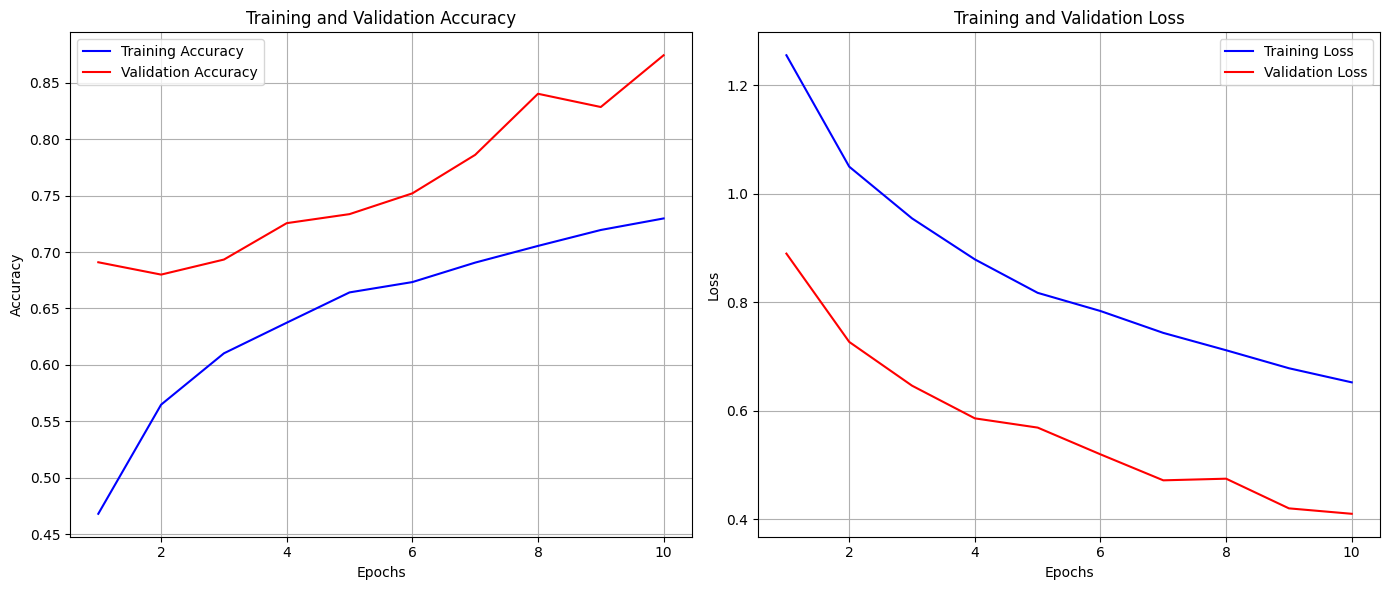

In [21]:
##### Model Performance Graph #########
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_model_performance(history):
    # Extract accuracy and loss history
    tr_accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    tr_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Get the number of epochs
    epochs = range(1, len(tr_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Call the function to plot performance using the history object
plot_model_performance(history1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


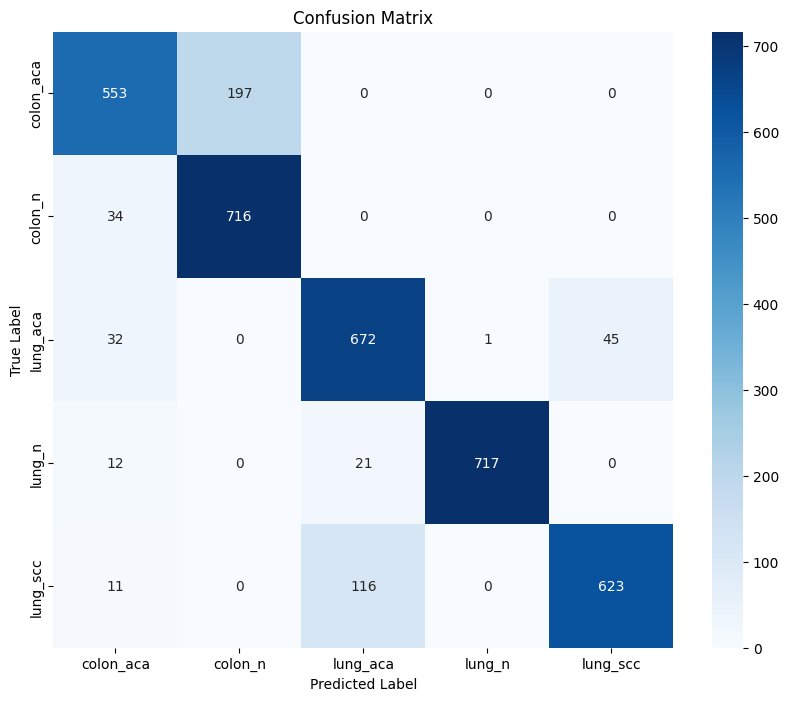

              precision    recall  f1-score   support

   colon_aca       0.86      0.74      0.79       750
     colon_n       0.78      0.95      0.86       750
    lung_aca       0.83      0.90      0.86       750
      lung_n       1.00      0.96      0.98       750
    lung_scc       0.93      0.83      0.88       750

    accuracy                           0.87      3750
   macro avg       0.88      0.87      0.87      3750
weighted avg       0.88      0.87      0.87      3750

Accuracy for class 'colon_aca': 0.74
Accuracy for class 'colon_n': 0.95
Accuracy for class 'lung_aca': 0.90
Accuracy for class 'lung_n': 0.96
Accuracy for class 'lung_scc': 0.83
Predicted class distribution: {0: 642, 1: 913, 2: 809, 3: 718, 4: 668}


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names according to your model
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Generate predictions
y_pred_prob = CNN_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate accuracy for each class
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[idx]:.2f}")

# Check the distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))



In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predict the class labels for the test data
y_pred = CNN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical from one-hot encoded to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Number of classes (assuming you know this or it's defined elsewhere)
num_classes = cm.shape[0]

# Calculate True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
TP = np.diag(cm)  # True Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Calculate the Error Rate for each class
total_samples_per_class = cm.sum(axis=1)
error_rate = FN / total_samples_per_class

# Display the results
df_cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
print("Confusion Matrix:")
print(df_cm)

print("\nTrue Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):")
for i in range(num_classes):
    print(f"Class {i}: TP = {TP[i]}, FN = {FN[i]}, FP = {FP[i]}, TN = {TN[i]}, Error Rate = {error_rate[i]:.4f}")

# True Positive Rate (TPR), also known as Sensitivity or Recall
TPR = TP / (TP + FN)  # TPR = TP / (TP + FN)

# False Positive Rate (FPR)
FPR = FP / (FP + TN)  # FPR = FP / (FP + TN)

# False Negative Rate (FNR)
FNR = FN / (TP + FN)  # FNR = FN / (TP + FN)

# True Negative Rate (TNR), also known as Specificity
TNR = TN / (TN + FP)  # TNR = TN / (TN + FP)

# Print TPR, FPR, FNR, and TNR for each class
print("\nTrue Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):")
for i in range(num_classes):
    print(f"Class {i}: TPR = {TPR[i]:.4f}, FPR = {FPR[i]:.4f}, FNR = {FNR[i]:.4f}, TNR = {TNR[i]:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
     0    1    2    3    4
0  553  197    0    0    0
1   34  716    0    0    0
2   32    0  672    1   45
3   12    0   21  717    0
4   11    0  116    0  623

True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):
Class 0: TP = 553, FN = 197, FP = 89, TN = 2911, Error Rate = 0.2627
Class 1: TP = 716, FN = 34, FP = 197, TN = 2803, Error Rate = 0.0453
Class 2: TP = 672, FN = 78, FP = 137, TN = 2863, Error Rate = 0.1040
Class 3: TP = 717, FN = 33, FP = 1, TN = 2999, Error Rate = 0.0440
Class 4: TP = 623, FN = 127, FP = 45, TN = 2955, Error Rate = 0.1693

True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):
Class 0: TPR = 0.7373, FPR = 0.0297, FNR = 0.2627, TNR = 0.9703
Class 1: TPR = 0.9547, FPR = 0.0657, FNR = 0.0453, TNR = 0.9343
Class 2: TPR = 0.8960, FPR = 0.0457, FNR = 0.1040, TNR = 0.9543
Class 3: TPR = 0.9560, FPR = 0.0003, FNR =

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


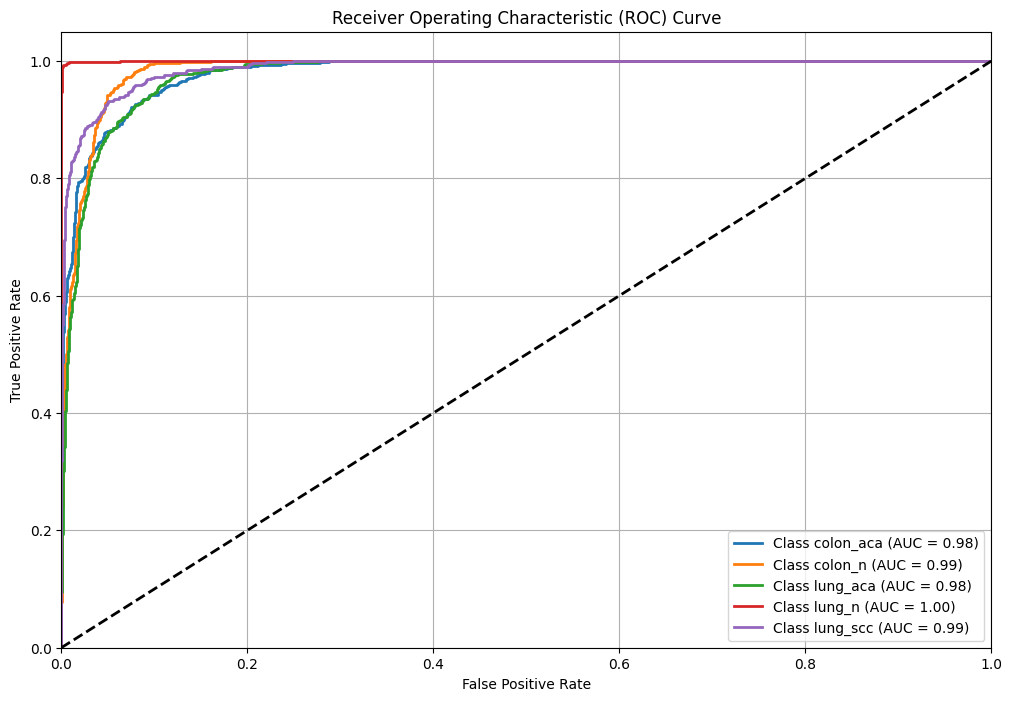

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = CNN_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for ROC computation
y_test_binary = y_test_categorical

# Binarize the output for ROC computation
n_classes = y_test_categorical.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import roc_auc_score

# For each class
y_test_prob = CNN_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    auc = roc_auc_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} AUC: {auc}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Class 0 AUC: 0.9808022222222221
Class 1 AUC: 0.9851697777777777
Class 2 AUC: 0.9778715555555554
Class 3 AUC: 0.9998586666666667
Class 4 AUC: 0.9880995555555556


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


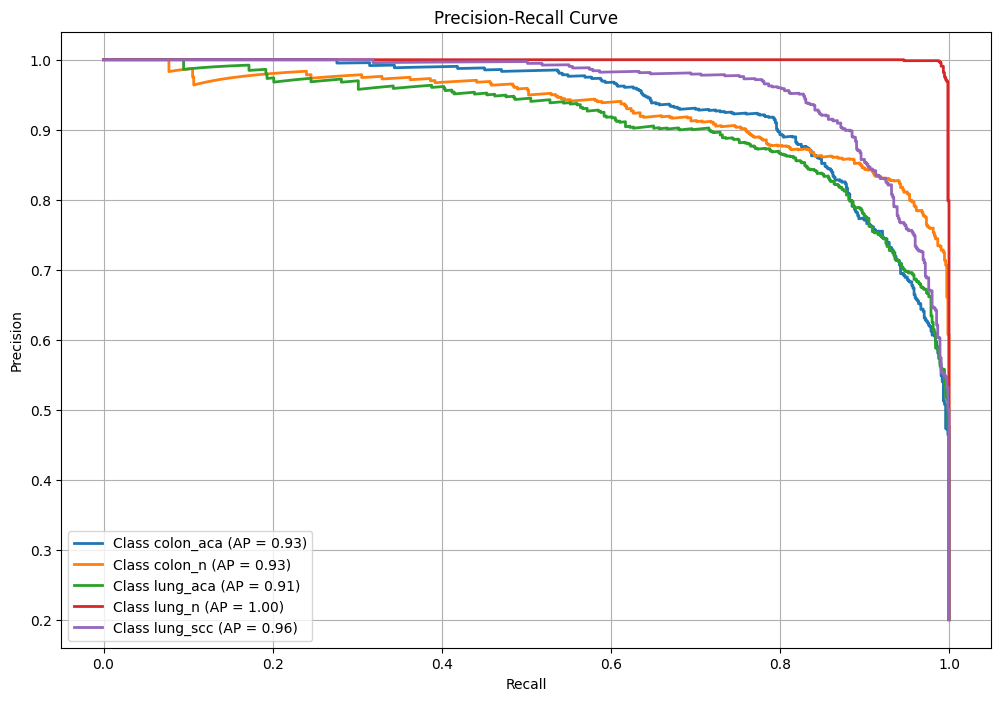

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = CNN_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for PR computation
y_test_binary = y_test_categorical

# Binarize the output for PR computation
n_classes = y_test_categorical.shape[1]

# Compute Precision-Recall curve and PR area for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_binary[:, i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [27]:
y_test_prob = CNN_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_categorical[:, i], y_test_prob[:, i])
    ap_score = average_precision_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} Average Precision (AP): {ap_score}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Class 0 Average Precision (AP): 0.9344161072783742
Class 1 Average Precision (AP): 0.9315558460644924
Class 2 Average Precision (AP): 0.9110585894482683
Class 3 Average Precision (AP): 0.9995038547176547
Class 4 Average Precision (AP): 0.960221304179496


In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Evaluate the model on the training, validation, and test sets immediately after training
train_eval = CNN_model.evaluate(X_train, y_train_categorical, verbose=0)
final_tr_loss = train_eval[0]  # Training loss
final_tr_acc = train_eval[1]   # Training accuracy

val_eval = CNN_model.evaluate(X_val, y_val_categorical, verbose=0)
val_loss = val_eval[0]         # Validation loss
val_acc = val_eval[1]          # Validation accuracy

test_eval = CNN_model.evaluate(X_test, y_test_categorical, verbose=0)
test_loss = test_eval[0]       # Test loss
test_acc = test_eval[1]        # Test accuracy

# Extract details from the CNN_model
def extract_model_details(model):
    num_conv_layers = sum(1 for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Conv2D))
    max_num_filters = max((layer.filters for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), default=0)
    num_dense_layers = sum(1 for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Dense))
    neurons_first_hidden = next((layer.units for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Dense)), None)
    dropout_rate = next((layer.rate for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Dropout)), None)
    learning_rate = CNN_model.optimizer.learning_rate.numpy()
    
    # Extract padding type used in convolutional layers
    padding_type = next((layer.padding for layer in CNN_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)
    
    return {
        'num_conv_layers': num_conv_layers,
        'max_num_filters': max_num_filters,
        'num_dense_layers': num_dense_layers,
        'neurons_first_hidden': neurons_first_hidden,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'padding_type': padding_type  # Padding type used in Conv layers
    }

# Get details from CNN_model
cnn_model_details = extract_model_details(CNN_model)

# Create or update the DataFrame to capture the CNN model details including total accuracy
CNN_model_details = pd.DataFrame(data={
    'Model_Name': ['CNN_model'],
    'tr_loss': [final_tr_loss],   # Updated training loss
    'val_loss': [val_loss],        # Updated validation loss
    'test_loss': [test_loss],      # Updated test loss
    'tr_acc': [final_tr_acc],      # Updated training accuracy
    'val_acc': [val_acc],          # Updated validation accuracy
    'test_acc': [test_acc],        # Updated test accuracy
    'num_conv_layers': [cnn_model_details['num_conv_layers']],
    'max_num_filters': [cnn_model_details['max_num_filters']],
    'num_dense_layers': [cnn_model_details['num_dense_layers']],
    'neurons_first_hidden': [cnn_model_details['neurons_first_hidden']],
    'dropout_rate': [cnn_model_details['dropout_rate']],
    'learning_rate': [cnn_model_details['learning_rate']],
    'padding': [cnn_model_details['padding_type']],  # Added padding type
    'epochs': [len(history1.history['loss'])],  # Number of epochs used in training
})

# # All details will be concatenated with other model details
combined_model_details1 = pd.concat([CNN_model_details], ignore_index=True)

# Display the combined DataFrame
combined_model_details1


Model_Name   tr_loss  val_loss  test_loss  tr_acc  val_acc  test_acc  \
0  CNN_model  0.394687  0.409875    0.40386  0.8944   0.8744  0.874933   

   num_conv_layers  max_num_filters  num_dense_layers  neurons_first_hidden  \
0                4               64                 3                    32   

   dropout_rate  learning_rate padding  epochs  
0           0.5         0.0001    same      10

# 2.EfficientNetB0 Model

In [29]:
######### EfficientNetB0 Model ############

In [30]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

def create_compact_model(input_shape, num_classes, dropout_rate=0.4):
    """Build a compact model using EfficientNetB0 as a feature extractor."""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    
    # Add Global Average Pooling
    model.add(GlobalAveragePooling2D())
    
    # Add Fully Connected Layers
    model.add(Dense(64, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(128, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Define hyperparameters
input_shape = X_train.shape[1:]  # Use the shape from your preprocessed training data
num_classes = y_train_categorical.shape[1]  # Number of classes based on your categorical labels

# Create the EfficientNetB0-based model using the Sequential API
EfficientNetB0_model = create_compact_model(input_shape, num_classes, dropout_rate=0.4)

# Force the model to build
dummy_input = np.zeros((1, *input_shape))
EfficientNetB0_model.predict(dummy_input)


# Print model summary
EfficientNetB0_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (1, 7, 7, 1280)        │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 64)                │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 128)               │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 5)                 │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,140,520 (15.79 MB)

 Trainable params: 90,949 (355.27 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax

# Define the number of epochs
epochs = 10


# Compile the EfficientNetB0 model
EfficientNetB0_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model using the preprocessed and augmented data
history2 = EfficientNetB0_model.fit(
    X_train,  # Training data
    y_train_categorical,  # Training labels
    epochs=epochs,  # Number of epochs
    callbacks=[early_stopping_callback],  # List of callbacks
    validation_data=(X_val, y_val_categorical),  # Validation data and labels
    verbose=1  # Verbosity mode
)


Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 92s 104ms/step - accuracy: 0.3583 - loss: 1.4903 - val_accuracy: 0.8069 - val_loss: 0.8980
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7040 - loss: 0.8726 - val_accuracy: 0.8733 - val_loss: 0.4940
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.7887 - loss: 0.5999 - val_accuracy: 0.9064 - val_loss: 0.3458
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8329 - loss: 0.4739 - val_accuracy: 0.9197 - val_loss: 0.2794
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8566 - loss: 0.4109 - val_accuracy: 0.9275 - val_loss: 0.2423
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.8708 - loss: 0.3569 - val_accuracy: 0.9301 - val_loss: 0.2132
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8853 - loss: 0.3272 - val_accuracy: 0.9339 - val_loss: 0.1988
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8973 - loss: 0.3015 -

In [33]:
def evaluate_and_print_model_performance(model, X_train, y_train_categorical, X_val, y_val_categorical, X_test, y_test_categorical):
    """
    Evaluate and print the performance of the model on the training, validation, and test datasets.

    Parameters:
    - model: The trained Keras model
    - X_train: Training data features
    - y_train_categorical: Training data labels in categorical format
    - X_val: Validation data features
    - y_val_categorical: Validation data labels in categorical format
    - X_test: Test data features
    - y_test_categorical: Test data labels in categorical format
    """
    
    # Evaluate the model on the training data
    train_eval = model.evaluate(X_train, y_train_categorical, verbose=0)
    final_tr_loss = train_eval[0]
    final_tr_acc = train_eval[1]
    
    # Evaluate the model on the validation data
    val_eval = model.evaluate(X_val, y_val_categorical, verbose=0)
    val_loss = val_eval[0]
    val_acc = val_eval[1]
    
    # Evaluate the model on the test data
    test_eval = model.evaluate(X_test, y_test_categorical, verbose=0)
    test_loss = test_eval[0]
    test_acc = test_eval[1]
    
    # Print the results
    print(f'Training Loss: {final_tr_loss:.4f}, Training Accuracy: {final_tr_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Calculate overall accuracy and loss
    overall_accuracy = (final_tr_acc + val_acc + test_acc) / 3
    overall_loss = (final_tr_loss + val_loss + test_loss) / 3

    # Print overall loss and accuracy
    print(f'Overall Loss: {overall_loss:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    
    # Return the results
    return final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy

# Assuming X_train, y_train_categorical, X_val, y_val_categorical, X_test, and y_test_categorical are defined
# Call the function and capture the results
final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy = evaluate_and_print_model_performance(
    EfficientNetB0_model,
    X_train,
    y_train_categorical,
    X_val,
    y_val_categorical,
    X_test,
    y_test_categorical
)


Training Loss: 0.1463, Training Accuracy: 0.9495
Validation Loss: 0.1582, Validation Accuracy: 0.9440
Test Loss: 0.1487, Test Accuracy: 0.9483
Overall Loss: 0.1511
Overall Accuracy: 0.9473


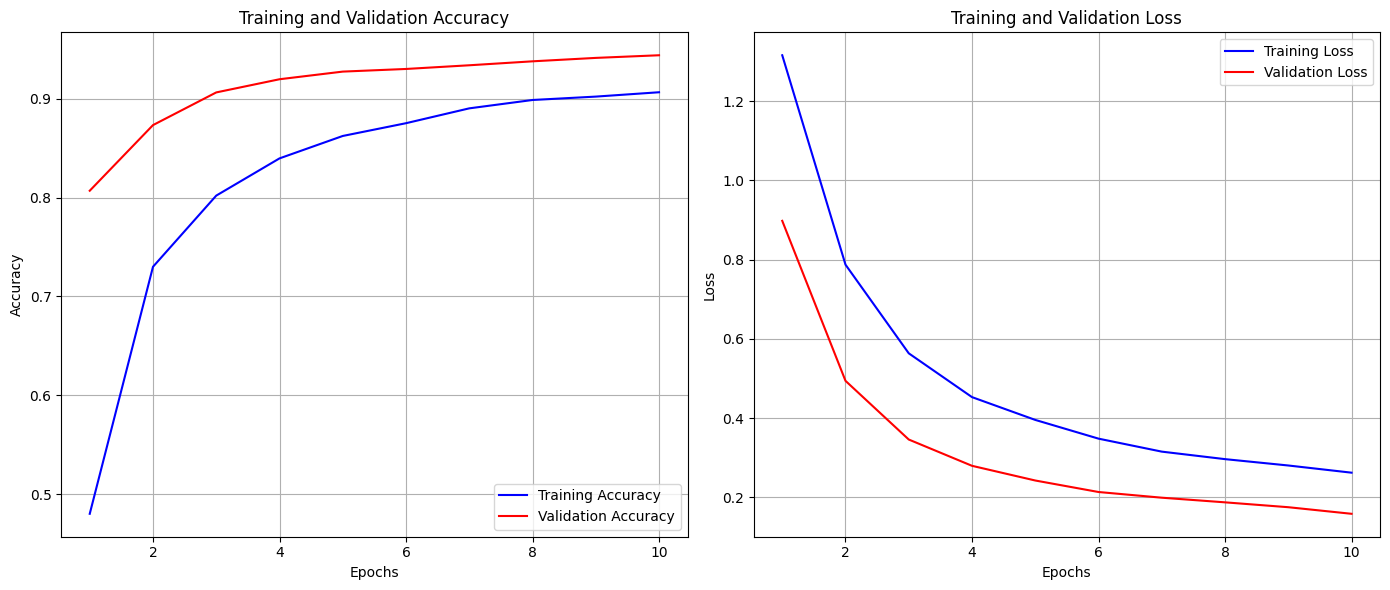

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_model_performance(history):
    # Extract accuracy and loss history
    tr_accuracy = history2.history.get('accuracy', [])
    val_accuracy = history2.history.get('val_accuracy', [])
    tr_loss = history2.history.get('loss', [])
    val_loss = history2.history.get('val_loss', [])

    # Get the number of epochs
    epochs = range(1, len(tr_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Call the function to plot performance using the history object
plot_model_performance(history2)

118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step


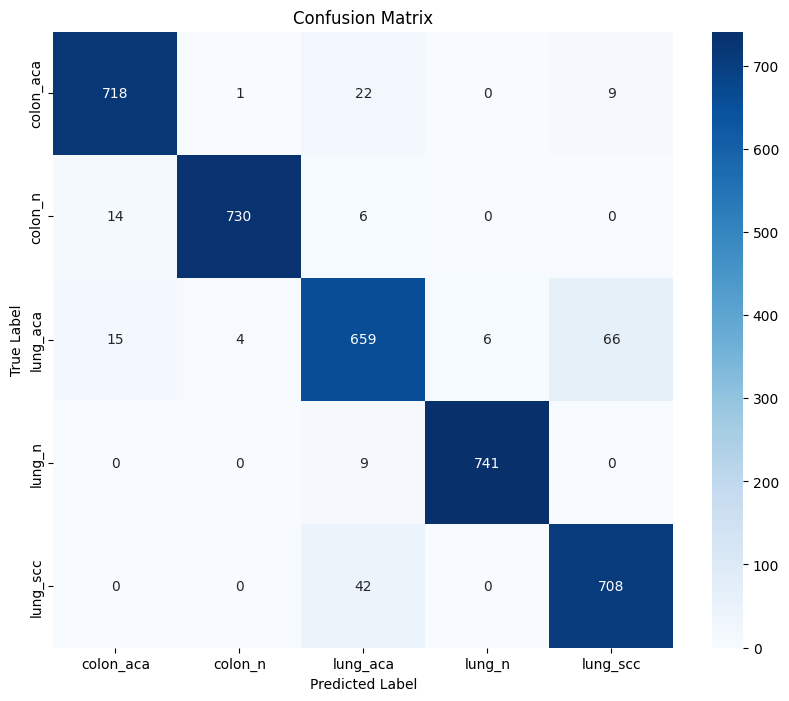

              precision    recall  f1-score   support

   colon_aca       0.96      0.96      0.96       750
     colon_n       0.99      0.97      0.98       750
    lung_aca       0.89      0.88      0.89       750
      lung_n       0.99      0.99      0.99       750
    lung_scc       0.90      0.94      0.92       750

    accuracy                           0.95      3750
   macro avg       0.95      0.95      0.95      3750
weighted avg       0.95      0.95      0.95      3750

Accuracy for class 'colon_aca': 0.96
Accuracy for class 'colon_n': 0.97
Accuracy for class 'lung_aca': 0.88
Accuracy for class 'lung_n': 0.99
Accuracy for class 'lung_scc': 0.94
Predicted class distribution: {0: 747, 1: 735, 2: 738, 3: 747, 4: 783}


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names according to your model
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Generate predictions
y_pred_prob = EfficientNetB0_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate accuracy for each class
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[idx]:.2f}")

# Check the distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))


In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predict the class labels for the test data
y_pred = EfficientNetB0_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical from one-hot encoded to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Number of classes (assuming you know this or it's defined elsewhere)
num_classes = cm.shape[0]

# Calculate True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
TP = np.diag(cm)  # True Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Calculate the Error Rate for each class
total_samples_per_class = cm.sum(axis=1)
error_rate = FN / total_samples_per_class

# Display the results
df_cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
print("Confusion Matrix:")
print(df_cm)

print("\nTrue Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):")
for i in range(num_classes):
    print(f"Class {i}: TP = {TP[i]}, FN = {FN[i]}, FP = {FP[i]}, TN = {TN[i]}, Error Rate = {error_rate[i]:.4f}")
    
# True Positive Rate (TPR), also known as Sensitivity or Recall
TPR = TP / (TP + FN)  # TPR = TP / (TP + FN)

# False Positive Rate (FPR)
FPR = FP / (FP + TN)  # FPR = FP / (FP + TN)

# False Negative Rate (FNR)
FNR = FN / (TP + FN)  # FNR = FN / (TP + FN)

# True Negative Rate (TNR), also known as Specificity
TNR = TN / (TN + FP)  # TNR = TN / (TN + FP)

# Print TPR, FPR, FNR, and TNR for each class
print("\nTrue Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):")
for i in range(num_classes):
    print(f"Class {i}: TPR = {TPR[i]:.4f}, FPR = {FPR[i]:.4f}, FNR = {FNR[i]:.4f}, TNR = {TNR[i]:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Confusion Matrix:
     0    1    2    3    4
0  718    1   22    0    9
1   14  730    6    0    0
2   15    4  659    6   66
3    0    0    9  741    0
4    0    0   42    0  708

True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):
Class 0: TP = 718, FN = 32, FP = 29, TN = 2971, Error Rate = 0.0427
Class 1: TP = 730, FN = 20, FP = 5, TN = 2995, Error Rate = 0.0267
Class 2: TP = 659, FN = 91, FP = 79, TN = 2921, Error Rate = 0.1213
Class 3: TP = 741, FN = 9, FP = 6, TN = 2994, Error Rate = 0.0120
Class 4: TP = 708, FN = 42, FP = 75, TN = 2925, Error Rate = 0.0560

True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):
Class 0: TPR = 0.9573, FPR = 0.0097, FNR = 0.0427, TNR = 0.9903
Class 1: TPR = 0.9733, FPR = 0.0017, FNR = 0.0267, TNR = 0.9983
Class 2: TPR = 0.8787, FPR = 0.0263, FNR = 0.1213, TNR = 0.9737
Class 3: TPR = 0.9880, FPR = 0.0020, FNR = 0.01

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


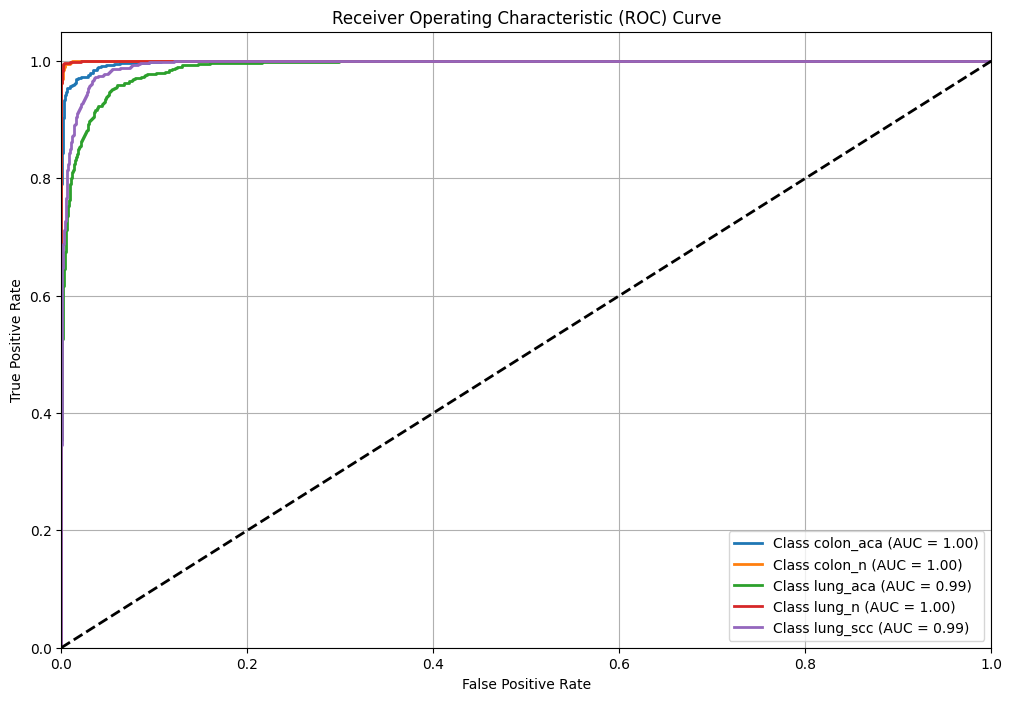

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = EfficientNetB0_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for ROC computation
y_test_binary = y_test_categorical

# Binarize the output for ROC computation
n_classes = y_test_categorical.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import roc_auc_score

# For each class
y_test_prob = EfficientNetB0_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    auc = roc_auc_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} AUC: {auc}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Class 0 AUC: 0.9981111111111112
Class 1 AUC: 0.9998813333333333
Class 2 AUC: 0.9893755555555556
Class 3 AUC: 0.9999142222222223
Class 4 AUC: 0.9945857777777778


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


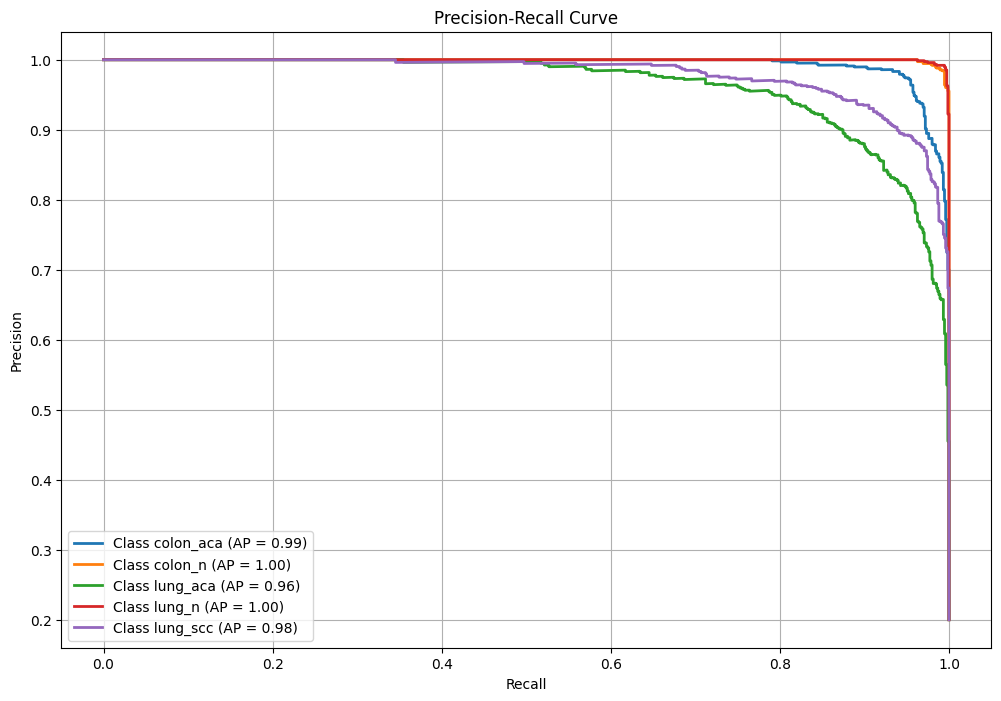

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = EfficientNetB0_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for PR computation
y_test_binary = y_test_categorical

# Binarize the output for PR computation
n_classes = y_test_categorical.shape[1]

# Compute Precision-Recall curve and PR area for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_binary[:, i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [40]:
y_test_prob = EfficientNetB0_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_categorical[:, i], y_test_prob[:, i])
    ap_score = average_precision_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} Average Precision (AP): {ap_score}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Class 0 Average Precision (AP): 0.993197827069924
Class 1 Average Precision (AP): 0.9995324827068954
Class 2 Average Precision (AP): 0.9620296958104058
Class 3 Average Precision (AP): 0.9996663437955792
Class 4 Average Precision (AP): 0.9783470252504425


In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Evaluate the EfficientNetB0 model on the training, validation, and test sets immediately after training
train_eval = EfficientNetB0_model.evaluate(X_train, y_train_categorical, verbose=0)
final_tr_loss = train_eval[0]  # Training loss
final_tr_acc = train_eval[1]   # Training accuracy

val_eval = EfficientNetB0_model.evaluate(X_val, y_val_categorical, verbose=0)
val_loss = val_eval[0]         # Validation loss
val_acc = val_eval[1]          # Validation accuracy

test_eval = EfficientNetB0_model.evaluate(X_test, y_test_categorical, verbose=0)
test_loss = test_eval[0]       # Test loss
test_acc = test_eval[1]        # Test accuracy

# Extract details from the EfficientNetB0_model
def extract_model_details(model):
    num_conv_layers = sum(1 for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Conv2D))
    max_num_filters = max((layer.filters for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), default=0)
    num_dense_layers = sum(1 for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Dense))
    neurons_first_hidden = next((layer.units for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Dense)), None)
    dropout_rate = next((layer.rate for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Dropout)), None)
    learning_rate = EfficientNetB0_model.optimizer.learning_rate.numpy()
    
    # Extract padding type used in convolutional layers
    padding_type = next((layer.padding for layer in EfficientNetB0_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)
    
    return {
        'num_conv_layers': num_conv_layers,
        'max_num_filters': max_num_filters,
        'num_dense_layers': num_dense_layers,
        'neurons_first_hidden': neurons_first_hidden,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'padding_type': padding_type  # Padding type used in Conv layers
    }

# Get details from EfficientNetB0_model
efficientnet_details = extract_model_details(EfficientNetB0_model)

# Create or update the DataFrame to capture the EfficientNetB0 model details including total accuracy
EfficientNetB0_model_details = pd.DataFrame(data={
    'Model_Name': ['EfficientNetB0_model'],
    'tr_loss': [final_tr_loss],   # Updated training loss
    'val_loss': [val_loss],        # Updated validation loss
    'test_loss': [test_loss],      # Updated test loss
    'tr_acc': [final_tr_acc],      # Updated training accuracy
    'val_acc': [val_acc],          # Updated validation accuracy
    'test_acc': [test_acc],        # Updated test accuracy
    'num_conv_layers': [efficientnet_details['num_conv_layers']],
    'max_num_filters': [efficientnet_details['max_num_filters']],
    'num_dense_layers': [efficientnet_details['num_dense_layers']],
    'neurons_first_hidden': [efficientnet_details['neurons_first_hidden']],
    'dropout_rate': [efficientnet_details['dropout_rate']],
    'learning_rate': [efficientnet_details['learning_rate']],
    'padding': [efficientnet_details['padding_type']],  # Added padding type
    'epochs': [len(history2.history['loss'])],  # Number of epochs used in training
})

# All details will be concatenated with other model details
combined_model_details2 = pd.concat([CNN_model_details, EfficientNetB0_model_details], ignore_index=True)

# Display the combined DataFrame
combined_model_details2

Model_Name   tr_loss  val_loss  test_loss    tr_acc  val_acc  \
0             CNN_model  0.394687  0.409875   0.403860  0.894400   0.8744   
1  EfficientNetB0_model  0.146291  0.158191   0.148725  0.949486   0.9440   

   test_acc  num_conv_layers  max_num_filters  num_dense_layers  \
0  0.874933                4               64                 3   
1  0.948267                0                0                 3   

   neurons_first_hidden  dropout_rate  learning_rate padding  epochs  
0                    32           0.5         0.0001    same      10  
1                    64           0.4         0.0001    None      10

# 3.Transformer (ViT) Model

In [42]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from rich.progress import track

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Reshape, Embedding, LayerNormalization, MultiHeadAttention, Dense, Add, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model

def create_vit_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Patch embedding layer
    patch_size = (16, 16)  # Define patch size
    num_patches = (input_shape[0] // patch_size[0]) * (input_shape[1] // patch_size[1])
    
    x = Conv2D(filters=64, kernel_size=patch_size, strides=patch_size, padding ='valid')(inputs)
    x = Reshape(target_shape=(num_patches, 64))(x)
    
    # Positional encoding
    position_embedding = Embedding(input_dim=num_patches, output_dim=64)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_encoded = position_embedding(positions)
    
    x = x + position_encoded

    # Transformer blocks
    num_transformer_blocks = 4  # Reduced number of blocks
    for _ in range(num_transformer_blocks):
        x1 = LayerNormalization()(x)
        attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x1, x1)
        x2 = Add()([attention_output, x1])
        x3 = LayerNormalization()(x2)
        ffn_output = Dense(128, activation='relu')(x3)  # Reduced size
        ffn_output = Dense(64)(ffn_output)
        x = Add()([ffn_output, x2])
        x = Dropout(0.4)(x)  # Added dropout within Transformer blocks

    # Classification head
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)  # Reduced size
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    Vit_model = Model(inputs, outputs)
    return Vit_model


In [44]:
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ensure all labels are in the label mapping
for label in np.unique(y_test):
    if label not in label_mapping:
        print(f"Label '{label}' not found in label mapping.")

y_train_int = np.array([label_mapping[label] for label in y_train])
y_val_int = np.array([label_mapping[label] for label in y_val])
y_test_int = np.array([label_mapping[label] for label in y_test])

# Convert labels to categorical
num_classes = len(label_mapping)
y_train_categorical = to_categorical(y_train_int, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_int, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_int, num_classes=num_classes)

# Create and compile the model
input_shape = (224, 224, 3)  # Adjust according to your input images
Vit_model = create_vit_model(input_shape, num_classes)

Vit_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [45]:
# Print the model summary
Vit_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │     49,216 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 64)   │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 196, 64)   │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ dense_7[0][0],    │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 196, 64)   │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 196, 64)   │      8,256 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 196, 64)   │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_3[0][0]     

 Total params: 391,109 (1.49 MB)

 Trainable params: 391,109 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model using the preprocessed and augmented data
history3 = Vit_model.fit(
    create_dataset(X_train, y_train_categorical),
    validation_data=create_dataset(X_val, y_val_categorical),
    epochs=10,  # Adjust as needed
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/10


I0000 00:00:1727384713.033245     788 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_24', 1084 bytes spill stores, 1084 bytes spill loads

I0000 00:00:1727384725.949872     787 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_26', 1080 bytes spill stores, 1080 bytes spill loads



547/547 ━━━━━━━━━━━━━━━━━━━━ 117s 118ms/step - accuracy: 0.3290 - loss: 1.4771 - val_accuracy: 0.6496 - val_loss: 0.8156
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.5764 - loss: 0.9867 - val_accuracy: 0.6928 - val_loss: 0.6839
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6440 - loss: 0.8274 - val_accuracy: 0.6944 - val_loss: 0.6528
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.6711 - loss: 0.7477 - val_accuracy: 0.7651 - val_loss: 0.5681
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7108 - loss: 0.6698 - val_accuracy: 0.7901 - val_loss: 0.5242
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7504 - loss: 0.5991 - val_accuracy: 0.8147 - val_loss: 0.4601
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7801 - loss: 0.5407 - val_accuracy: 0.8344 - val_loss: 0.4309
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7954 - loss: 0.5068 - val_accur

In [47]:
def evaluate_and_print_model_performance(model, X_train, y_train_categorical, X_val, y_val_categorical, X_test, y_test_categorical):
    """
    Evaluate and print the performance of the model on the training, validation, and test datasets.

    Parameters:
    - model: The trained Keras model
    - X_train: Training data features
    - y_train_categorical: Training data labels in categorical format
    - X_val: Validation data features
    - y_val_categorical: Validation data labels in categorical format
    - X_test: Test data features
    - y_test_categorical: Test data labels in categorical format
    """
    
    # Evaluate the model on the training data
    train_eval = model.evaluate(X_train, y_train_categorical, verbose=0)
    final_tr_loss = train_eval[0]
    final_tr_acc = train_eval[1]
    
    # Evaluate the model on the validation data
    val_eval = model.evaluate(X_val, y_val_categorical, verbose=0)
    val_loss = val_eval[0]
    val_acc = val_eval[1]
    
    # Evaluate the model on the test data
    test_eval = model.evaluate(X_test, y_test_categorical, verbose=0)
    test_loss = test_eval[0]
    test_acc = test_eval[1]
    
    # Print the results
    print(f'Training Loss: {final_tr_loss:.4f}, Training Accuracy: {final_tr_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Calculate overall accuracy and loss
    overall_accuracy = (final_tr_acc + val_acc + test_acc) / 3
    overall_loss = (final_tr_loss + val_loss + test_loss) / 3

    # Print overall loss and accuracy
    print(f'Overall Loss: {overall_loss:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    
    # Return the results
    return final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy

# Call the function and capture the results
final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy = evaluate_and_print_model_performance(
    Vit_model,
    X_train,
    y_train_categorical,
    X_val,
    y_val_categorical,
    X_test,
    y_test_categorical
)


Training Loss: 0.4150, Training Accuracy: 0.8271
Validation Loss: 0.3970, Validation Accuracy: 0.8347
Test Loss: 0.3950, Test Accuracy: 0.8352
Overall Loss: 0.4023
Overall Accuracy: 0.8323


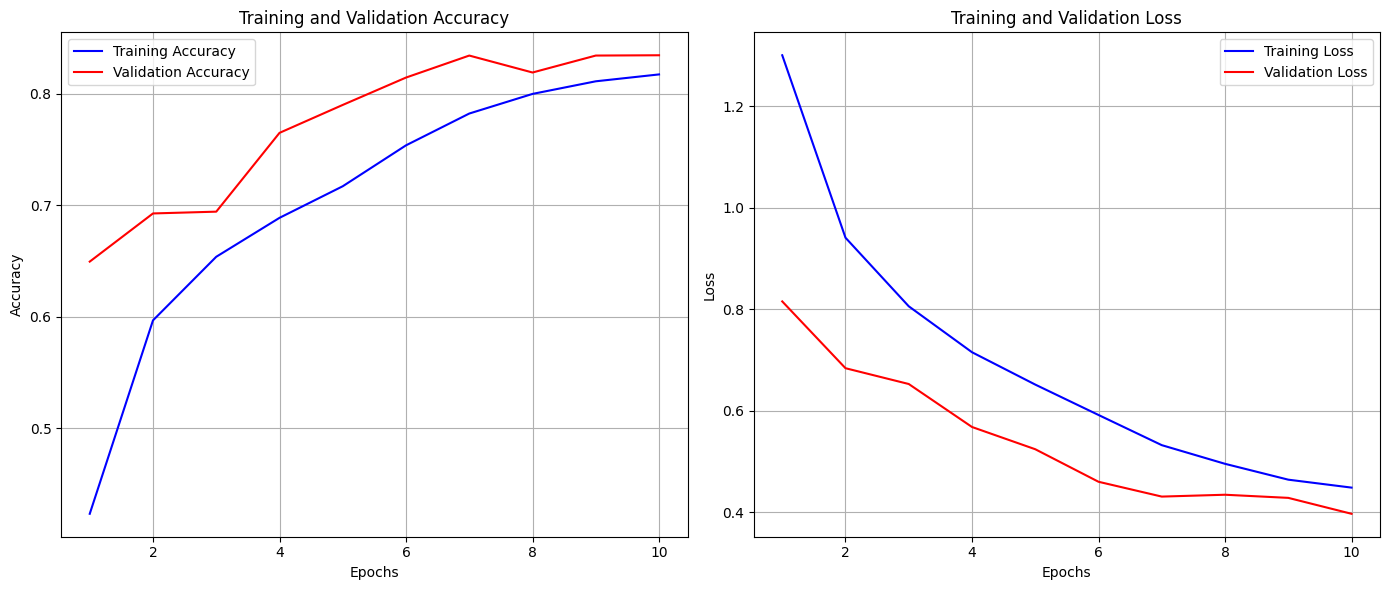

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_model_performance(history):
    # Extract accuracy and loss history
    tr_accuracy = history3.history.get('accuracy', [])
    val_accuracy = history3.history.get('val_accuracy', [])
    tr_loss = history3.history.get('loss', [])
    val_loss = history3.history.get('val_loss', [])

    # Get the number of epochs
    epochs = range(1, len(tr_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Call the function to plot performance using the history object
plot_model_performance(history3)

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


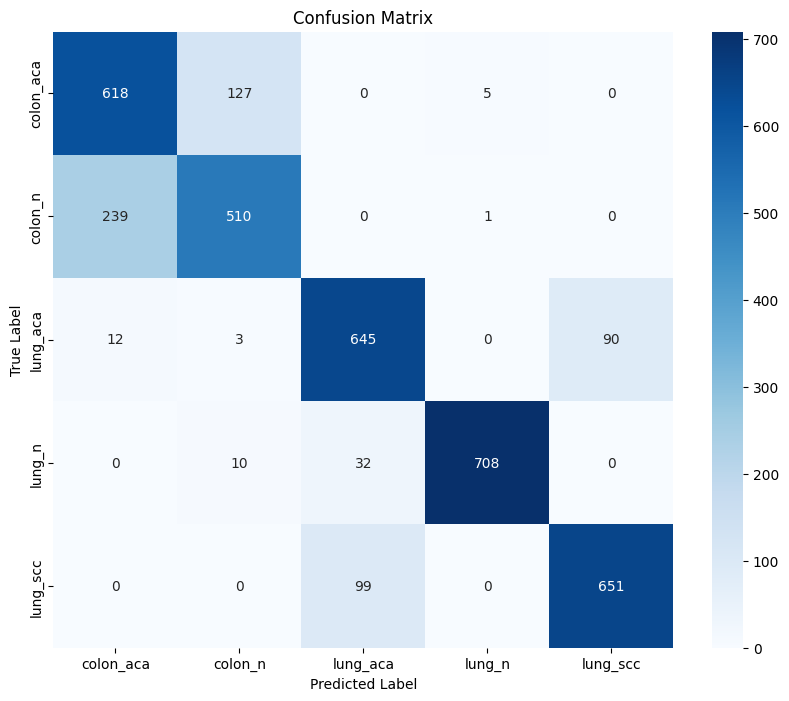

              precision    recall  f1-score   support

   colon_aca       0.71      0.82      0.76       750
     colon_n       0.78      0.68      0.73       750
    lung_aca       0.83      0.86      0.85       750
      lung_n       0.99      0.94      0.97       750
    lung_scc       0.88      0.87      0.87       750

    accuracy                           0.84      3750
   macro avg       0.84      0.84      0.84      3750
weighted avg       0.84      0.84      0.84      3750

Accuracy for class 'colon_aca': 0.82
Accuracy for class 'colon_n': 0.68
Accuracy for class 'lung_aca': 0.86
Accuracy for class 'lung_n': 0.94
Accuracy for class 'lung_scc': 0.87
Predicted class distribution: {0: 869, 1: 650, 2: 776, 3: 714, 4: 741}


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names according to your model
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Generate predictions
y_pred_prob = Vit_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate accuracy for each class
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[idx]:.2f}")
    
# Check the distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))


In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predict the class labels for the test data
y_pred = Vit_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical from one-hot encoded to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Number of classes (assuming you know this or it's defined elsewhere)
num_classes = cm.shape[0]

# Calculate True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
TP = np.diag(cm)  # True Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Calculate the Error Rate for each class
total_samples_per_class = cm.sum(axis=1)
error_rate = FN / total_samples_per_class

# Display the results
df_cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
print("Confusion Matrix:")
print(df_cm)

print("\nTrue Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):")
for i in range(num_classes):
    print(f"Class {i}: TP = {TP[i]}, FN = {FN[i]}, FP = {FP[i]}, TN = {TN[i]}, Error Rate = {error_rate[i]:.4f}")
    
# True Positive Rate (TPR), also known as Sensitivity or Recall
TPR = TP / (TP + FN)  # TPR = TP / (TP + FN)

# False Positive Rate (FPR)
FPR = FP / (FP + TN)  # FPR = FP / (FP + TN)

# False Negative Rate (FNR)
FNR = FN / (TP + FN)  # FNR = FN / (TP + FN)

# True Negative Rate (TNR), also known as Specificity
TNR = TN / (TN + FP)  # TNR = TN / (TN + FP)

# Print TPR, FPR, FNR, and TNR for each class
print("\nTrue Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):")
for i in range(num_classes):
    print(f"Class {i}: TPR = {TPR[i]:.4f}, FPR = {FPR[i]:.4f}, FNR = {FNR[i]:.4f}, TNR = {TNR[i]:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
     0    1    2    3    4
0  618  127    0    5    0
1  239  510    0    1    0
2   12    3  645    0   90
3    0   10   32  708    0
4    0    0   99    0  651

True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):
Class 0: TP = 618, FN = 132, FP = 251, TN = 2749, Error Rate = 0.1760
Class 1: TP = 510, FN = 240, FP = 140, TN = 2860, Error Rate = 0.3200
Class 2: TP = 645, FN = 105, FP = 131, TN = 2869, Error Rate = 0.1400
Class 3: TP = 708, FN = 42, FP = 6, TN = 2994, Error Rate = 0.0560
Class 4: TP = 651, FN = 99, FP = 90, TN = 2910, Error Rate = 0.1320

True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):
Class 0: TPR = 0.8240, FPR = 0.0837, FNR = 0.1760, TNR = 0.9163
Class 1: TPR = 0.6800, FPR = 0.0467, FNR = 0.3200, TNR = 0.9533
Class 2: TPR = 0.8600, FPR = 0.0437, FNR = 0.1400, TNR = 0.9563
Class 3: TPR = 0.9440, FPR = 0.0020, FNR

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


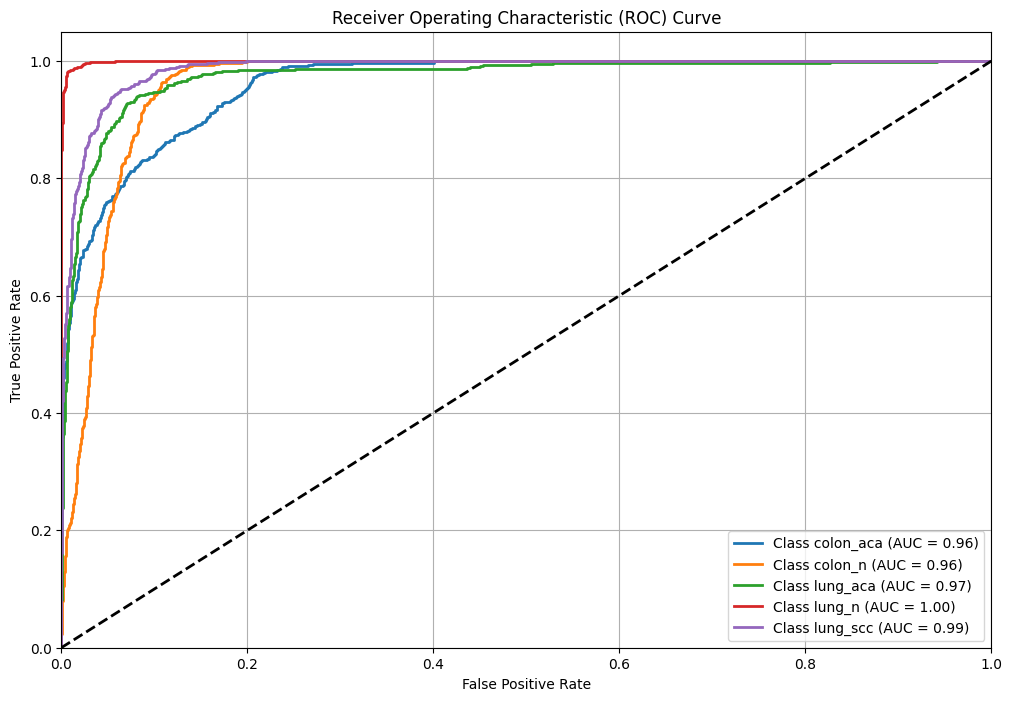

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = Vit_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for ROC computation
y_test_binary = y_test_categorical

# Binarize the output for ROC computation
n_classes = y_test_categorical.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [52]:
from sklearn.metrics import roc_auc_score

# For each class
y_test_prob = Vit_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    auc = roc_auc_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} AUC: {auc}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Class 0 AUC: 0.9605222222222222
Class 1 AUC: 0.9613262222222222
Class 2 AUC: 0.9736737777777777
Class 3 AUC: 0.9993106666666666
Class 4 AUC: 0.986404


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


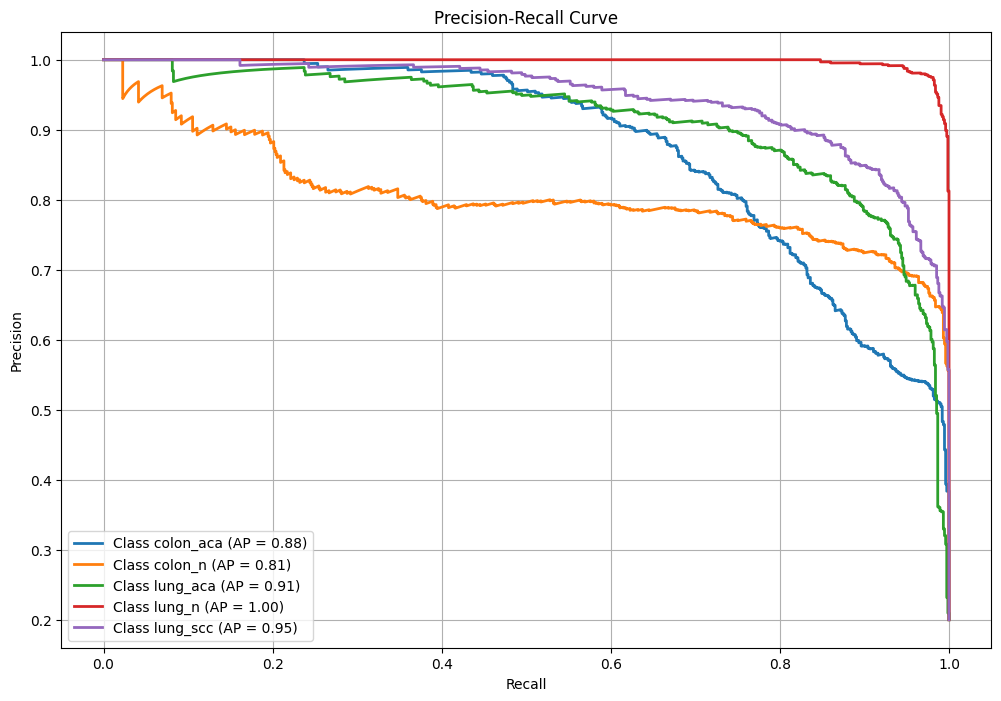

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = Vit_model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for PR computation
y_test_binary = y_test_categorical

# Binarize the output for PR computation
n_classes = y_test_categorical.shape[1]

# Compute Precision-Recall curve and PR area for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_binary[:, i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [54]:
y_test_prob = Vit_model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_categorical[:, i], y_test_prob[:, i])
    ap_score = average_precision_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} Average Precision (AP): {ap_score}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Class 0 Average Precision (AP): 0.8791603926702161
Class 1 Average Precision (AP): 0.8070622615461703
Class 2 Average Precision (AP): 0.9125137988458566
Class 3 Average Precision (AP): 0.9973322005258157
Class 4 Average Precision (AP): 0.9459457236207577


In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Evaluate the Vit_model on the training, validation, and test sets immediately after training
train_eval = Vit_model.evaluate(X_train, y_train_categorical, verbose=0)
final_tr_loss = train_eval[0]  # Training loss
final_tr_acc = train_eval[1]   # Training accuracy

val_eval = Vit_model.evaluate(X_val, y_val_categorical, verbose=0)
val_loss = val_eval[0]         # Validation loss
val_acc = val_eval[1]          # Validation accuracy

test_eval = Vit_model.evaluate(X_test, y_test_categorical, verbose=0)
test_loss = test_eval[0]       # Test loss
test_acc = test_eval[1]        # Test accuracy

# Extract details from the Vit_model
def extract_model_details(model):
    num_conv_layers = sum(1 for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Conv2D))
    max_num_filters = max((layer.filters for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), default=0)
    num_dense_layers = sum(1 for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Dense))
    neurons_first_hidden = next((layer.units for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Dense)), None)
    dropout_rate = next((layer.rate for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Dropout)), None)
    learning_rate = Vit_model.optimizer.learning_rate.numpy()
    
    # Extract padding type used in convolutional layers
    padding_type = next((layer.padding for layer in Vit_model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)
    
    return {
        'num_conv_layers': num_conv_layers,
        'max_num_filters': max_num_filters,
        'num_dense_layers': num_dense_layers,
        'neurons_first_hidden': neurons_first_hidden,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'padding_type': padding_type  # Padding type used in Conv layers
    }

# Get details from Vit_model
Vit_model_details = extract_model_details(Vit_model)

# Create or update the DataFrame to capture the Vit_model details including total accuracy
Vit_model_details = pd.DataFrame(data={
    'Model_Name': ['Vit_model'],
    'tr_loss': [final_tr_loss],   # Updated training loss
    'val_loss': [val_loss],        # Updated validation loss
    'test_loss': [test_loss],      # Updated test loss
    'tr_acc': [final_tr_acc],      # Updated training accuracy
    'val_acc': [val_acc],          # Updated validation accuracy
    'test_acc': [test_acc],        # Updated test accuracy
    'num_conv_layers': [Vit_model_details['num_conv_layers']],
    'max_num_filters': [Vit_model_details['max_num_filters']],
    'num_dense_layers': [Vit_model_details['num_dense_layers']],
    'neurons_first_hidden': [Vit_model_details['neurons_first_hidden']],
    'dropout_rate': [Vit_model_details['dropout_rate']],
    'learning_rate': [Vit_model_details['learning_rate']],
    'padding': [Vit_model_details['padding_type']],  # Added padding type
    'epochs': [len(history3.history['loss'])],  # Number of epochs used in training
})

# All details will be concatenated with other model details
combined_model_details3 = pd.concat([CNN_model_details, EfficientNetB0_model_details, Vit_model_details], ignore_index=True)

# Display the combined DataFrame
combined_model_details3

Model_Name   tr_loss  val_loss  test_loss    tr_acc   val_acc  \
0             CNN_model  0.394687  0.409875   0.403860  0.894400  0.874400   
1  EfficientNetB0_model  0.146291  0.158191   0.148725  0.949486  0.944000   
2             Vit_model  0.415023  0.396971   0.394960  0.827143  0.834667   

   test_acc  num_conv_layers  max_num_filters  num_dense_layers  \
0  0.874933                4               64                 3   
1  0.948267                0                0                 3   
2  0.835200                1               64                10   

   neurons_first_hidden  dropout_rate  learning_rate padding  epochs  
0                    32           0.5        0.00010    same      10  
1                    64           0.4        0.00010    None      10  
2                   128           0.4        0.00001   valid      10

# 4.RESNET Model

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [57]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Ensure all labels are in the label mapping
for label in np.unique(y_test):
    if label not in label_mapping:
        print(f"Label '{label}' not found in label mapping.")

# Convert labels to integer format
y_train_int = np.array([label_mapping[label] for label in y_train])
y_val_int = np.array([label_mapping[label] for label in y_val])
y_test_int = np.array([label_mapping[label] for label in y_test])

# Convert labels to categorical (one-hot encoding)
num_classes = len(label_mapping)
y_train_categorical = to_categorical(y_train_int, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_int, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_int, num_classes=num_classes)


In [58]:
import tensorflow as tf

def create_dataset(X, y, batch_size=32, shuffle=True):
    """
    Create a TensorFlow dataset from the given data.

    Args:
    - X: numpy array of images
    - y: numpy array of labels
    - batch_size: size of the batches to return
    - shuffle: whether to shuffle the data

    Returns:
    - A tf.data.Dataset object
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets
batch_size = 32  # Adjust as needed

train_dataset = create_dataset(X_train, y_train_categorical, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(X_val, y_val_categorical, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test_categorical, batch_size=batch_size, shuffle=False)


In [59]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut path with optional down-sampling
    shortcut = x
    if stride != 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Convolutional path
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Adding shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x


In [60]:
def initial_layers(inputs):
    x = Conv2D(64, (7, 7), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    return x


In [61]:
def create_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Layers
    x = initial_layers(inputs)
    
    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)  # Changing filter size and stride
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)  # Changing filter size and stride
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)  # Changing filter size and stride
    x = residual_block(x, 512)
    
    # Global Average Pooling and Fully Connected Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    x = Dense(num_classes, activation='softmax')(x)
    
    ResNet_Model = Model(inputs, x)
    return ResNet_Model

# Create the model
ResNet_Model = create_resnet_model(input_shape=(224, 224, 3), num_classes=5)

# Print the model summary
ResNet_Model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_9[0][0]  

 Total params: 11,323,525 (43.20 MB)

 Trainable params: 11,313,925 (43.16 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [62]:
from tensorflow.keras.optimizers import Adam

# Define your ResNet model
input_shape = (224, 224, 3)  # Adjust according to your input images
num_classes = len(label_mapping)

ResNet_Model = create_resnet_model(input_shape, num_classes)  # Assume create_resnet_model is defined

# Compile the model
ResNet_Model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)

# Train the ResNet model
history4 = ResNet_Model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,  # Adjust as needed
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 110s 149ms/step - accuracy: 0.6755 - loss: 0.8348 - val_accuracy: 0.7536 - val_loss: 1.0769
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.9126 - loss: 0.2307 - val_accuracy: 0.9333 - val_loss: 0.1823
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 63s 116ms/step - accuracy: 0.9375 - loss: 0.1607 - val_accuracy: 0.8731 - val_loss: 0.3860
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 64s 117ms/step - accuracy: 0.9544 - loss: 0.1198 - val_accuracy: 0.9333 - val_loss: 0.1714
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 64s 117ms/step - accuracy: 0.9632 - loss: 0.0936 - val_accuracy: 0.9547 - val_loss: 0.1219


In [64]:
def evaluate_and_print_model_performance(model, X_train, y_train_categorical, X_val, y_val_categorical, X_test, y_test_categorical):
    """
    Evaluate and print the performance of the model on the training, validation, and test datasets.

    Parameters:
    - model: The trained Keras model
    - X_train: Training data features
    - y_train_categorical: Training data labels in categorical format
    - X_val: Validation data features
    - y_val_categorical: Validation data labels in categorical format
    - X_test: Test data features
    - y_test_categorical: Test data labels in categorical format
    """
    
    # Evaluate the model on the training data
    train_eval = model.evaluate(X_train, y_train_categorical, verbose=0)
    final_tr_loss = train_eval[0]
    final_tr_acc = train_eval[1]
    
    # Evaluate the model on the validation data
    val_eval = model.evaluate(X_val, y_val_categorical, verbose=0)
    val_loss = val_eval[0]
    val_acc = val_eval[1]
    
    # Evaluate the model on the test data
    test_eval = model.evaluate(X_test, y_test_categorical, verbose=0)
    test_loss = test_eval[0]
    test_acc = test_eval[1]
    
    # Print the results
    print(f'Training Loss: {final_tr_loss:.4f}, Training Accuracy: {final_tr_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Calculate overall accuracy and loss
    overall_accuracy = (final_tr_acc + val_acc + test_acc) / 3
    overall_loss = (final_tr_loss + val_loss + test_loss) / 3

    # Print overall loss and accuracy
    print(f'Overall Loss: {overall_loss:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    
    # Return the results
    return final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy

# Call the function and capture the results
final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy = evaluate_and_print_model_performance(
    ResNet_Model,
    X_train,
    y_train_categorical,
    X_val,
    y_val_categorical,
    X_test,
    y_test_categorical
)


Training Loss: 0.0923, Training Accuracy: 0.9647
Validation Loss: 0.1219, Validation Accuracy: 0.9547
Test Loss: 0.1214, Test Accuracy: 0.9581
Overall Loss: 0.1119
Overall Accuracy: 0.9592


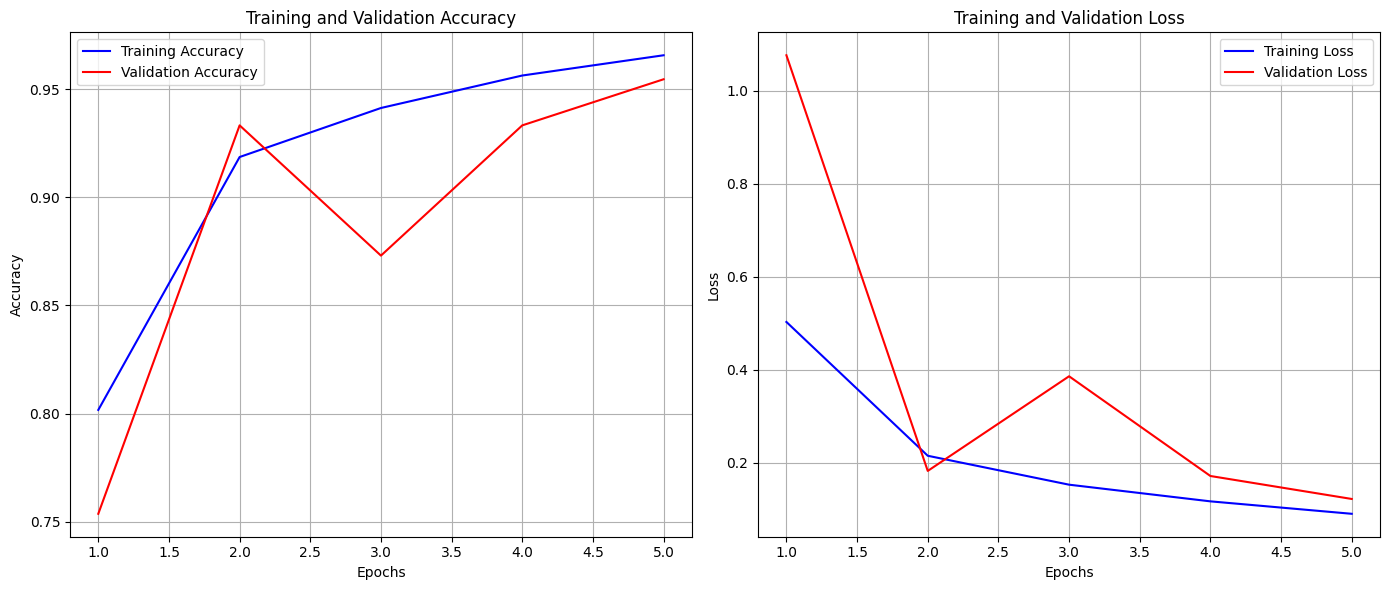

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_model_performance(history):
    # Extract accuracy and loss history
    tr_accuracy = history4.history.get('accuracy', [])
    val_accuracy = history4.history.get('val_accuracy', [])
    tr_loss = history4.history.get('loss', [])
    val_loss = history4.history.get('val_loss', [])

    # Get the number of epochs
    epochs = range(1, len(tr_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Call the function to plot performance using the history object
plot_model_performance(history4)

118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step


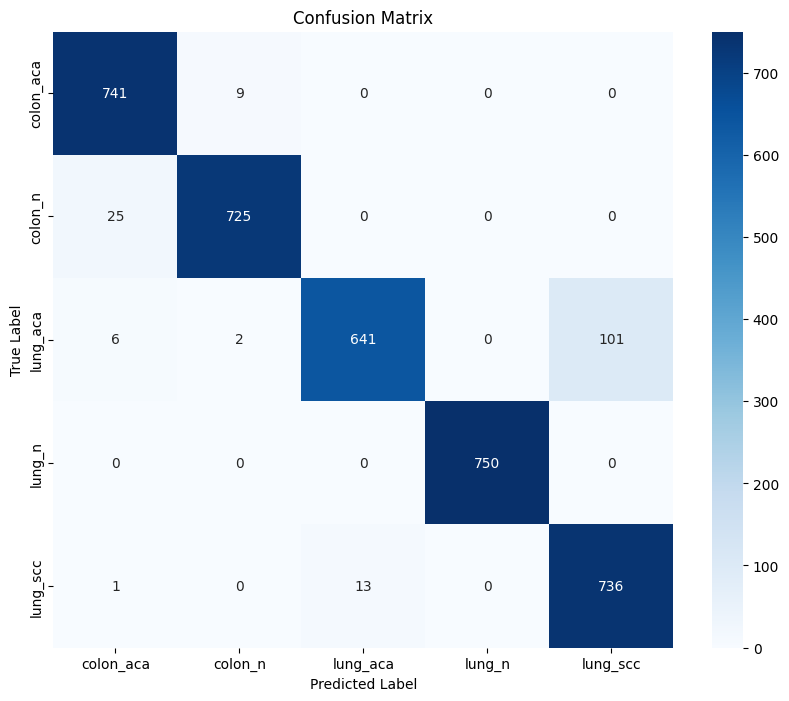

              precision    recall  f1-score   support

   colon_aca       0.96      0.99      0.97       750
     colon_n       0.99      0.97      0.98       750
    lung_aca       0.98      0.85      0.91       750
      lung_n       1.00      1.00      1.00       750
    lung_scc       0.88      0.98      0.93       750

    accuracy                           0.96      3750
   macro avg       0.96      0.96      0.96      3750
weighted avg       0.96      0.96      0.96      3750

Accuracy for class 'colon_aca': 0.99
Accuracy for class 'colon_n': 0.97
Accuracy for class 'lung_aca': 0.85
Accuracy for class 'lung_n': 1.00
Accuracy for class 'lung_scc': 0.98
Predicted class distribution: {0: 773, 1: 736, 2: 654, 3: 750, 4: 837}


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names according to your model
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Generate predictions
y_pred_prob = ResNet_Model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate accuracy for each class
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[idx]:.2f}")
    
# Check the distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))


In [67]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predict the class labels for the test data
y_pred = ResNet_Model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical from one-hot encoded to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Number of classes (assuming you know this or it's defined elsewhere)
num_classes = cm.shape[0]

# Calculate True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
TP = np.diag(cm)  # True Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Calculate the Error Rate for each class
total_samples_per_class = cm.sum(axis=1)
error_rate = FN / total_samples_per_class

# Display the results
df_cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
print("Confusion Matrix:")
print(df_cm)

print("\nTrue Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):")
for i in range(num_classes):
    print(f"Class {i}: TP = {TP[i]}, FN = {FN[i]}, FP = {FP[i]}, TN = {TN[i]}, Error Rate = {error_rate[i]:.4f}")
    
# True Positive Rate (TPR), also known as Sensitivity or Recall
TPR = TP / (TP + FN)  # TPR = TP / (TP + FN)

# False Positive Rate (FPR)
FPR = FP / (FP + TN)  # FPR = FP / (FP + TN)

# False Negative Rate (FNR)
FNR = FN / (TP + FN)  # FNR = FN / (TP + FN)

# True Negative Rate (TNR), also known as Specificity
TNR = TN / (TN + FP)  # TNR = TN / (TN + FP)

# Print TPR, FPR, FNR, and TNR for each class
print("\nTrue Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):")
for i in range(num_classes):
    print(f"Class {i}: TPR = {TPR[i]:.4f}, FPR = {FPR[i]:.4f}, FNR = {FNR[i]:.4f}, TNR = {TNR[i]:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Confusion Matrix:
     0    1    2    3    4
0  741    9    0    0    0
1   25  725    0    0    0
2    6    2  641    0  101
3    0    0    0  750    0
4    1    0   13    0  736

True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):
Class 0: TP = 741, FN = 9, FP = 32, TN = 2968, Error Rate = 0.0120
Class 1: TP = 725, FN = 25, FP = 11, TN = 2989, Error Rate = 0.0333
Class 2: TP = 641, FN = 109, FP = 13, TN = 2987, Error Rate = 0.1453
Class 3: TP = 750, FN = 0, FP = 0, TN = 3000, Error Rate = 0.0000
Class 4: TP = 736, FN = 14, FP = 101, TN = 2899, Error Rate = 0.0187

True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):
Class 0: TPR = 0.9880, FPR = 0.0107, FNR = 0.0120, TNR = 0.9893
Class 1: TPR = 0.9667, FPR = 0.0037, FNR = 0.0333, TNR = 0.9963
Class 2: TPR = 0.8547, FPR = 0.0043, FNR = 0.1453, TNR = 0.9957
Class 3: TPR = 1.0000, FPR = 0.0000, FNR = 0.

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


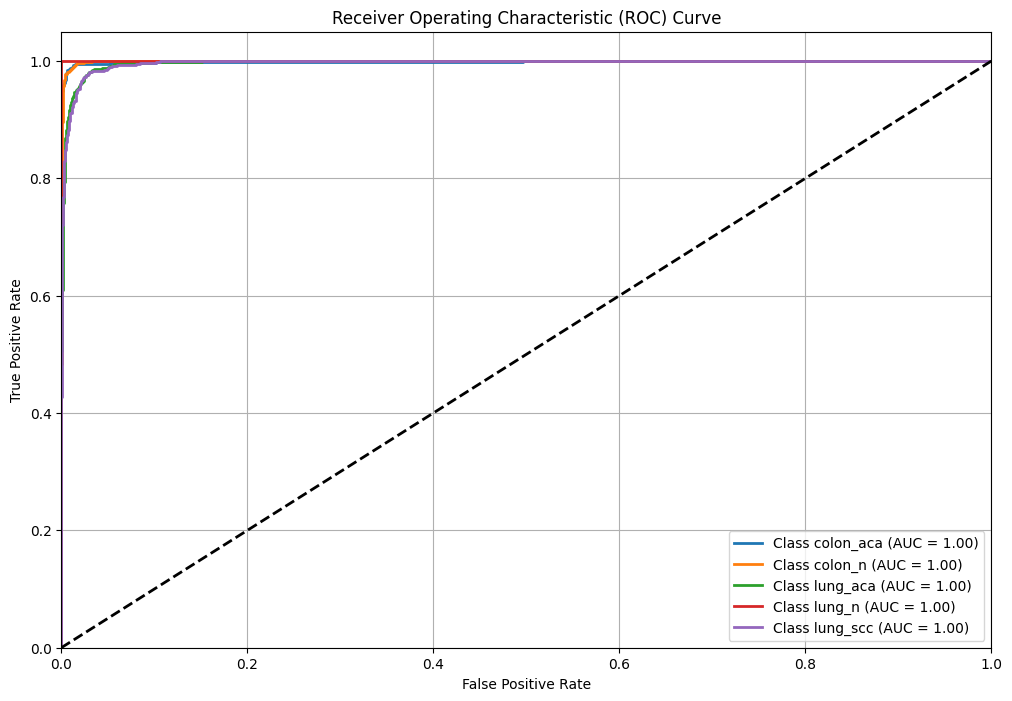

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = ResNet_Model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for ROC computation
y_test_binary = y_test_categorical

# Binarize the output for ROC computation
n_classes = y_test_categorical.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [69]:
from sklearn.metrics import roc_auc_score

# For each class
y_test_prob = ResNet_Model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    auc = roc_auc_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} AUC: {auc}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Class 0 AUC: 0.9987320000000002
Class 1 AUC: 0.9993679999999999
Class 2 AUC: 0.9967426666666667
Class 3 AUC: 1.0
Class 4 AUC: 0.9965644444444445


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


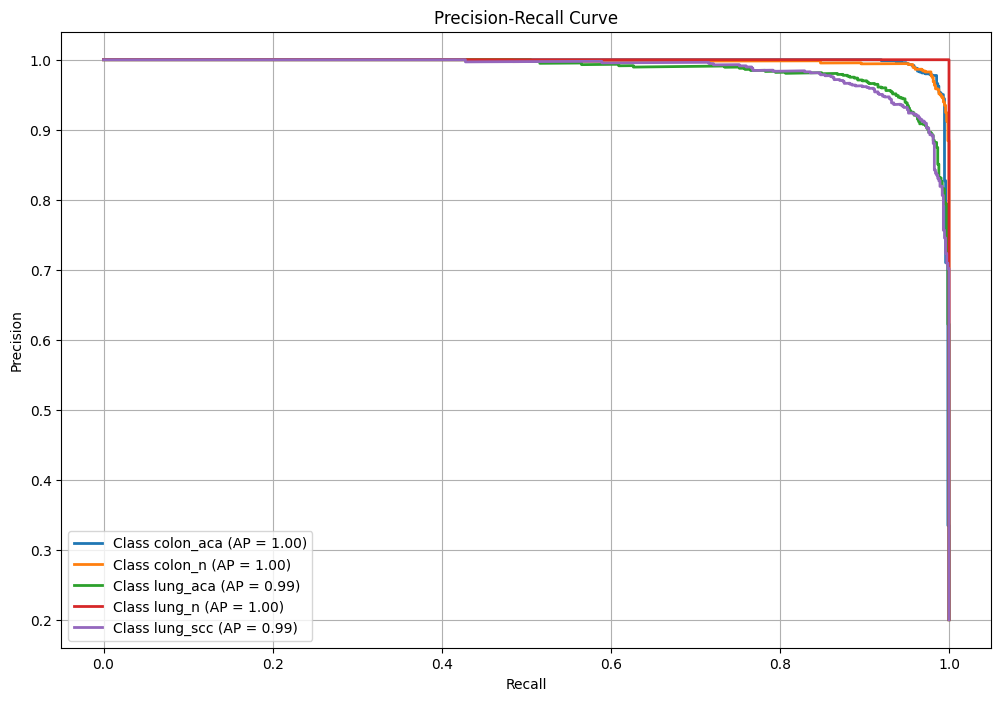

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = ResNet_Model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for PR computation
y_test_binary = y_test_categorical

# Binarize the output for PR computation
n_classes = y_test_categorical.shape[1]

# Compute Precision-Recall curve and PR area for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_binary[:, i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [71]:
y_test_prob = ResNet_Model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_categorical[:, i], y_test_prob[:, i])
    ap_score = average_precision_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} Average Precision (AP): {ap_score}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Class 0 Average Precision (AP): 0.9970554759732217
Class 1 Average Precision (AP): 0.9972248925365488
Class 2 Average Precision (AP): 0.9869197806976565
Class 3 Average Precision (AP): 0.9999999999999999
Class 4 Average Precision (AP): 0.9865739512946029


In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Evaluate the ResNet_Model on the training, validation, and test sets immediately after training
train_eval = ResNet_Model.evaluate(X_train, y_train_categorical, verbose=0)
final_tr_loss = train_eval[0]  # Training loss
final_tr_acc = train_eval[1]   # Training accuracy

val_eval = ResNet_Model.evaluate(X_val, y_val_categorical, verbose=0)
val_loss = val_eval[0]         # Validation loss
val_acc = val_eval[1]          # Validation accuracy

test_eval = ResNet_Model.evaluate(X_test, y_test_categorical, verbose=0)
test_loss = test_eval[0]       # Test loss
test_acc = test_eval[1]        # Test accuracy

# Extract details from the ResNet_Model
def extract_model_details(model):
    num_conv_layers = sum(1 for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Conv2D))
    max_num_filters = max((layer.filters for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Conv2D)), default=0)
    num_dense_layers = sum(1 for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Dense))
    neurons_first_hidden = next((layer.units for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Dense)), None)
    dropout_rate = next((layer.rate for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Dropout)), None)
    learning_rate = ResNet_Model.optimizer.learning_rate.numpy()
    
    # Extract padding type used in convolutional layers
    padding_type = next((layer.padding for layer in ResNet_Model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)
    
    return {
        'num_conv_layers': num_conv_layers,
        'max_num_filters': max_num_filters,
        'num_dense_layers': num_dense_layers,
        'neurons_first_hidden': neurons_first_hidden,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'padding_type': padding_type  # Padding type used in Conv layers
    }

# Get details from ResNet_Model
ResNet_Model_details = extract_model_details(ResNet_Model)

# Create or update the DataFrame to capture the Vit_model details including total accuracy
ResNet_Model_details = pd.DataFrame(data={
    'Model_Name': ['ResNet_Model'],
    'tr_loss': [final_tr_loss],   # Updated training loss
    'val_loss': [val_loss],        # Updated validation loss
    'test_loss': [test_loss],      # Updated test loss
    'tr_acc': [final_tr_acc],      # Updated training accuracy
    'val_acc': [val_acc],          # Updated validation accuracy
    'test_acc': [test_acc],        # Updated test accuracy
    'num_conv_layers': [ResNet_Model_details['num_conv_layers']],
    'max_num_filters': [ResNet_Model_details['max_num_filters']],
    'num_dense_layers': [ResNet_Model_details['num_dense_layers']],
    'neurons_first_hidden': [ResNet_Model_details['neurons_first_hidden']],
    'dropout_rate': [ResNet_Model_details['dropout_rate']],
    'learning_rate': [ResNet_Model_details['learning_rate']],
    'padding': [ResNet_Model_details['padding_type']],  # Added padding type
    'epochs': [len(history4.history['loss'])],  # Number of epochs used in training
})

# All details will be concatenated with other model details
combined_model_details4 = pd.concat([CNN_model_details, EfficientNetB0_model_details, Vit_model_details, ResNet_Model_details], ignore_index=True)

# Display the combined DataFrame
combined_model_details4

Model_Name   tr_loss  val_loss  test_loss    tr_acc   val_acc  \
0             CNN_model  0.394687  0.409875   0.403860  0.894400  0.874400   
1  EfficientNetB0_model  0.146291  0.158191   0.148725  0.949486  0.944000   
2             Vit_model  0.415023  0.396971   0.394960  0.827143  0.834667   
3          ResNet_Model  0.092291  0.121927   0.121406  0.964743  0.954667   

   test_acc  num_conv_layers  max_num_filters  num_dense_layers  \
0  0.874933                4               64                 3   
1  0.948267                0                0                 3   
2  0.835200                1               64                10   
3  0.958133               20              512                 2   

   neurons_first_hidden  dropout_rate  learning_rate padding  epochs  
0                    32           0.5        0.00010    same      10  
1                    64           0.4        0.00010    None      10  
2                   128           0.4        0.00001   valid      10  
3                   256           0.5        0.00001    same       5

# 5.VGG 16 Model

In [73]:
########### VGG 16 ###########

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define the VGG16 model
def create_vgg16_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create the custom top layers
    x = base_model.output
    x = Flatten()(x)  # Flatten the output of VGG16
    x = Dense(512, activation='relu')(x)  # Add a dense layer with ReLU activation
    x = Dropout(0.4)(x)  # Add dropout for regularization
    x = Dense(num_classes, activation='softmax')(x)  # Add final dense layer for classification

    # Define the new model
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Define the number of classes (replace with the actual number of classes)
num_classes = len(np.unique(y_train))  # Make sure y_train is defined

# Create the VGG16 model
VGG_16_Model = create_vgg16_model(num_classes)

# Print the model summary
VGG_16_Model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [75]:
VGG_16_Model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [76]:
history5 = VGG_16_Model.fit(
    X_train, y_train_categorical,
    epochs=5,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    validation_data=(X_val, y_val_categorical)
)


Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 133s 211ms/step - accuracy: 0.7735 - loss: 2.9351 - val_accuracy: 0.9373 - val_loss: 0.1719
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 90s 165ms/step - accuracy: 0.9302 - loss: 0.2154 - val_accuracy: 0.9549 - val_loss: 0.1250
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 91s 166ms/step - accuracy: 0.9590 - loss: 0.1204 - val_accuracy: 0.9557 - val_loss: 0.1611
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 90s 165ms/step - accuracy: 0.9648 - loss: 0.1127 - val_accuracy: 0.9597 - val_loss: 0.1265
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 90s 165ms/step - accuracy: 0.9728 - loss: 0.0848 - val_accuracy: 0.9653 - val_loss: 0.1272


In [77]:
def evaluate_and_print_model_performance(model, X_train, y_train_categorical, X_val, y_val_categorical, X_test, y_test_categorical):
    """
    Evaluate and print the performance of the model on the training, validation, and test datasets.

    Parameters:
    - model: The trained Keras model
    - X_train: Training data features
    - y_train_categorical: Training data labels in categorical format
    - X_val: Validation data features
    - y_val_categorical: Validation data labels in categorical format
    - X_test: Test data features
    - y_test_categorical: Test data labels in categorical format
    """
    
    # Evaluate the model on the training data
    train_eval = model.evaluate(X_train, y_train_categorical, verbose=0)
    final_tr_loss = train_eval[0]
    final_tr_acc = train_eval[1]
    
    # Evaluate the model on the validation data
    val_eval = model.evaluate(X_val, y_val_categorical, verbose=0)
    val_loss = val_eval[0]
    val_acc = val_eval[1]
    
    # Evaluate the model on the test data
    test_eval = model.evaluate(X_test, y_test_categorical, verbose=0)
    test_loss = test_eval[0]
    test_acc = test_eval[1]
    
    # Print the results
    print(f'Training Loss: {final_tr_loss:.4f}, Training Accuracy: {final_tr_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    # Calculate overall accuracy and loss
    overall_accuracy = (final_tr_acc + val_acc + test_acc) / 3
    overall_loss = (final_tr_loss + val_loss + test_loss) / 3

    # Print overall loss and accuracy
    print(f'Overall Loss: {overall_loss:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    
    # Return the results
    return final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy

# Call the function and capture the results
final_tr_loss, final_tr_acc, val_loss, val_acc, test_loss, test_acc, overall_loss, overall_accuracy = evaluate_and_print_model_performance(
    VGG_16_Model,
    X_train,
    y_train_categorical,
    X_val,
    y_val_categorical,
    X_test,
    y_test_categorical
)


Training Loss: 0.0300, Training Accuracy: 0.9895
Validation Loss: 0.1272, Validation Accuracy: 0.9653
Test Loss: 0.1145, Test Accuracy: 0.9709
Overall Loss: 0.0906
Overall Accuracy: 0.9753


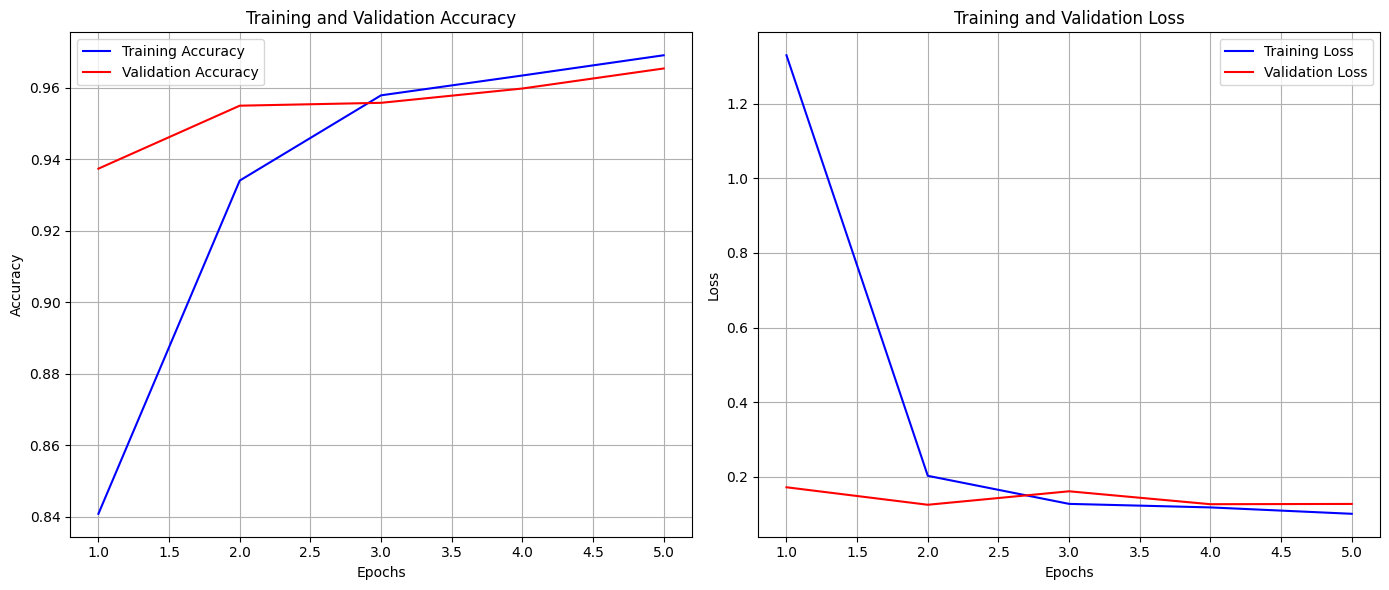

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_model_performance(history):
    # Extract accuracy and loss history
    tr_accuracy = history5.history.get('accuracy', [])
    val_accuracy = history5.history.get('val_accuracy', [])
    tr_loss = history5.history.get('loss', [])
    val_loss = history5.history.get('val_loss', [])

    # Get the number of epochs
    epochs = range(1, len(tr_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Call the function to plot performance using the history object
plot_model_performance(history5)

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step


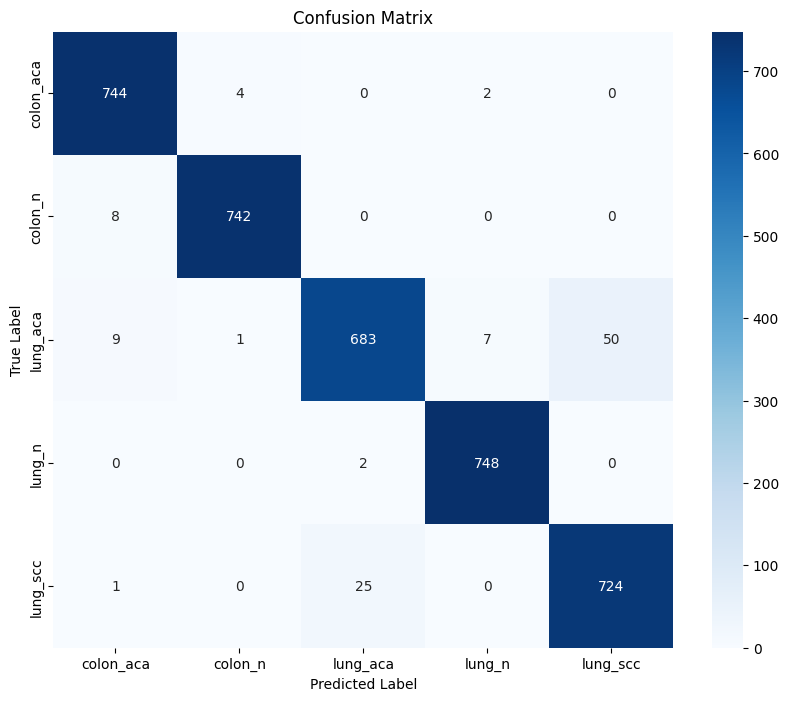

              precision    recall  f1-score   support

   colon_aca       0.98      0.99      0.98       750
     colon_n       0.99      0.99      0.99       750
    lung_aca       0.96      0.91      0.94       750
      lung_n       0.99      1.00      0.99       750
    lung_scc       0.94      0.97      0.95       750

    accuracy                           0.97      3750
   macro avg       0.97      0.97      0.97      3750
weighted avg       0.97      0.97      0.97      3750

Accuracy for class 'colon_aca': 0.99
Accuracy for class 'colon_n': 0.99
Accuracy for class 'lung_aca': 0.91
Accuracy for class 'lung_n': 1.00
Accuracy for class 'lung_scc': 0.97
Predicted class distribution: {0: 762, 1: 747, 2: 710, 3: 757, 4: 774}


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names according to your model
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

# Generate predictions
y_pred_prob = VGG_16_Model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate accuracy for each class
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_accuracies[idx]:.2f}")

# Check the distribution of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predict the class labels for the test data
y_pred = VGG_16_Model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical from one-hot encoded to class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Number of classes (assuming you know this or it's defined elsewhere)
num_classes = cm.shape[0]

# Calculate True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
TP = np.diag(cm)  # True Positives for each class
FN = cm.sum(axis=1) - TP  # False Negatives for each class
FP = cm.sum(axis=0) - TP  # False Positives for each class
TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class

# Calculate the Error Rate for each class
total_samples_per_class = cm.sum(axis=1)
error_rate = FN / total_samples_per_class

# Display the results
df_cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
print("Confusion Matrix:")
print(df_cm)

print("\nTrue Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):")
for i in range(num_classes):
    print(f"Class {i}: TP = {TP[i]}, FN = {FN[i]}, FP = {FP[i]}, TN = {TN[i]}, Error Rate = {error_rate[i]:.4f}")

# True Positive Rate (TPR), also known as Sensitivity or Recall
TPR = TP / (TP + FN)  # TPR = TP / (TP + FN)

# False Positive Rate (FPR)
FPR = FP / (FP + TN)  # FPR = FP / (FP + TN)

# False Negative Rate (FNR)
FNR = FN / (TP + FN)  # FNR = FN / (TP + FN)

# True Negative Rate (TNR), also known as Specificity
TNR = TN / (TN + FP)  # TNR = TN / (TN + FP)

# Print TPR, FPR, FNR, and TNR for each class
print("\nTrue Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):")
for i in range(num_classes):
    print(f"Class {i}: TPR = {TPR[i]:.4f}, FPR = {FPR[i]:.4f}, FNR = {FNR[i]:.4f}, TNR = {TNR[i]:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step
Confusion Matrix:
     0    1    2    3    4
0  744    4    0    2    0
1    8  742    0    0    0
2    9    1  683    7   50
3    0    0    2  748    0
4    1    0   25    0  724

True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN):
Class 0: TP = 744, FN = 6, FP = 18, TN = 2982, Error Rate = 0.0080
Class 1: TP = 742, FN = 8, FP = 5, TN = 2995, Error Rate = 0.0107
Class 2: TP = 683, FN = 67, FP = 27, TN = 2973, Error Rate = 0.0893
Class 3: TP = 748, FN = 2, FP = 9, TN = 2991, Error Rate = 0.0027
Class 4: TP = 724, FN = 26, FP = 50, TN = 2950, Error Rate = 0.0347

True Positive Rate (TPR), False Positive Rate (FPR), False Negative Rate (FNR), and True Negative Rate (TNR):
Class 0: TPR = 0.9920, FPR = 0.0060, FNR = 0.0080, TNR = 0.9940
Class 1: TPR = 0.9893, FPR = 0.0017, FNR = 0.0107, TNR = 0.9983
Class 2: TPR = 0.9107, FPR = 0.0090, FNR = 0.0893, TNR = 0.9910
Class 3: TPR = 0.9973, FPR = 0.0030, FNR = 0.00

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step


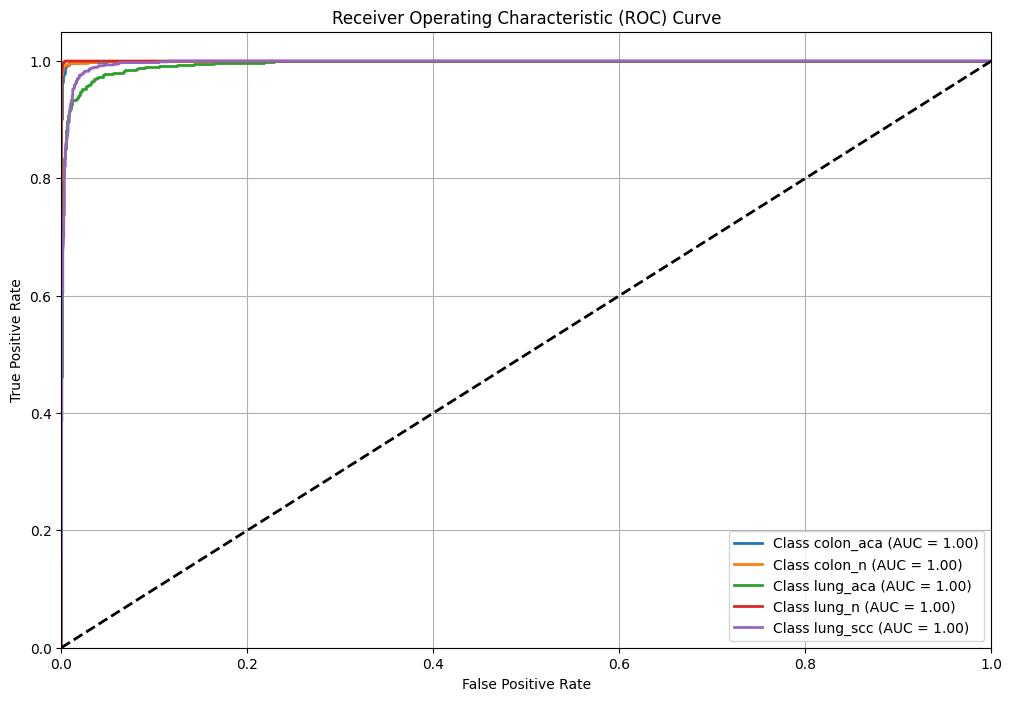

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = VGG_16_Model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for ROC computation
y_test_binary = y_test_categorical

# Binarize the output for ROC computation
n_classes = y_test_categorical.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [82]:
from sklearn.metrics import roc_auc_score

# For each class
y_test_prob = VGG_16_Model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    auc = roc_auc_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} AUC: {auc}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step
Class 0 AUC: 0.9997457777777777
Class 1 AUC: 0.9998622222222222
Class 2 AUC: 0.9952080000000001
Class 3 AUC: 0.9999684444444444
Class 4 AUC: 0.9967206666666667


118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step


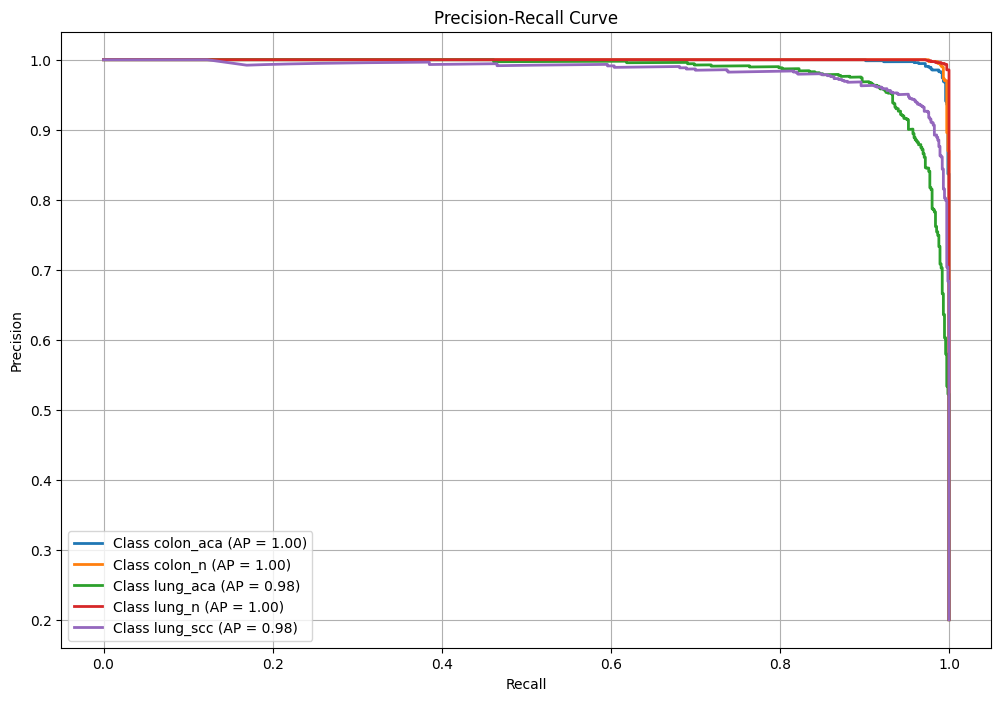

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test data
y_pred_probs = VGG_16_Model.predict(X_test)

# Convert y_test_categorical from one-hot encoded to binary format for PR computation
y_test_binary = y_test_categorical

# Binarize the output for PR computation
n_classes = y_test_categorical.shape[1]

# Compute Precision-Recall curve and PR area for each class
precision = {}
recall = {}
pr_auc = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_probs[:, i])
    pr_auc[i] = average_precision_score(y_test_binary[:, i], y_pred_probs[:, i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AP = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [84]:
y_test_prob = VGG_16_Model.predict(X_test)  # Predicted probabilities
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_categorical[:, i], y_test_prob[:, i])
    ap_score = average_precision_score(y_test_categorical[:, i], y_test_prob[:, i])
    print(f"Class {i} Average Precision (AP): {ap_score}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step
Class 0 Average Precision (AP): 0.9990280655923804
Class 1 Average Precision (AP): 0.9994931937732426
Class 2 Average Precision (AP): 0.983813276058085
Class 3 Average Precision (AP): 0.9998719301753725
Class 4 Average Precision (AP): 0.9847356641835481


In [85]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Evaluate the VGG_16_Model on the training, validation, and test sets immediately after training
train_eval = VGG_16_Model.evaluate(X_train, y_train_categorical, verbose=0)
final_tr_loss = train_eval[0]  # Training loss
final_tr_acc = train_eval[1]   # Training accuracy

val_eval = VGG_16_Model.evaluate(X_val, y_val_categorical, verbose=0)
val_loss = val_eval[0]         # Validation loss
val_acc = val_eval[1]          # Validation accuracy

test_eval = VGG_16_Model.evaluate(X_test, y_test_categorical, verbose=0)
test_loss = test_eval[0]       # Test loss
test_acc = test_eval[1]        # Test accuracy

# Extract details from the VGG_16_Model
def extract_model_details(model):
    num_conv_layers = sum(1 for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Conv2D))
    max_num_filters = max((layer.filters for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Conv2D)), default=0)
    num_dense_layers = sum(1 for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Dense))
    neurons_first_hidden = next((layer.units for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Dense)), None)
    dropout_rate = next((layer.rate for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Dropout)), None)
    learning_rate = VGG_16_Model.optimizer.learning_rate.numpy()
    
    # Extract padding type used in convolutional layers
    padding_type = next((layer.padding for layer in VGG_16_Model.layers if isinstance(layer, tf.keras.layers.Conv2D)), None)
    
    return {
        'num_conv_layers': num_conv_layers,
        'max_num_filters': max_num_filters,
        'num_dense_layers': num_dense_layers,
        'neurons_first_hidden': neurons_first_hidden,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'padding_type': padding_type  # Padding type used in Conv layers
    }

# Get details from VGG_16_Model
VGG_16_Model_details = extract_model_details(VGG_16_Model)

# Create or update the DataFrame to capture the VGG_16_Model_details including total accuracy
VGG_16_Model_details = pd.DataFrame(data={
    'Model_Name': ['VGG_16_Model'],
    'tr_loss': [final_tr_loss],   # Updated training loss
    'val_loss': [val_loss],        # Updated validation loss
    'test_loss': [test_loss],      # Updated test loss
    'tr_acc': [final_tr_acc],      # Updated training accuracy
    'val_acc': [val_acc],          # Updated validation accuracy
    'test_acc': [test_acc],        # Updated test accuracy
    'num_conv_layers': [VGG_16_Model_details['num_conv_layers']],
    'max_num_filters': [VGG_16_Model_details['max_num_filters']],
    'num_dense_layers': [VGG_16_Model_details['num_dense_layers']],
    'neurons_first_hidden': [VGG_16_Model_details['neurons_first_hidden']],
    'dropout_rate': [VGG_16_Model_details['dropout_rate']],
    'learning_rate': [VGG_16_Model_details['learning_rate']],
    'padding': [VGG_16_Model_details['padding_type']],  # Added padding type
    'epochs': [len(history5.history['loss'])],  # Number of epochs used in training
})

# All details will be concatenated with other model details
combined_model_details5 = pd.concat([CNN_model_details, EfficientNetB0_model_details, Vit_model_details, ResNet_Model_details, VGG_16_Model_details], ignore_index=True)

# Display the combined DataFrame
combined_model_details5

Model_Name   tr_loss  val_loss  test_loss    tr_acc   val_acc  \
0             CNN_model  0.394687  0.409875   0.403860  0.894400  0.874400   
1  EfficientNetB0_model  0.146291  0.158191   0.148725  0.949486  0.944000   
2             Vit_model  0.415023  0.396971   0.394960  0.827143  0.834667   
3          ResNet_Model  0.092291  0.121927   0.121406  0.964743  0.954667   
4          VGG_16_Model  0.029988  0.127224   0.114533  0.989543  0.965333   

   test_acc  num_conv_layers  max_num_filters  num_dense_layers  \
0  0.874933                4               64                 3   
1  0.948267                0                0                 3   
2  0.835200                1               64                10   
3  0.958133               20              512                 2   
4  0.970933               13              512                 2   

   neurons_first_hidden  dropout_rate  learning_rate padding  epochs  
0                    32           0.5        0.00010    same      10  
1                    64           0.4        0.00010    None      10  
2                   128           0.4        0.00001   valid      10  
3                   256           0.5        0.00001    same       5  
4                   512           0.4        0.00010    same       5

In [86]:
####### Test Any Model For Prediction #############

import numpy as np
from tensorflow.keras.models import Model

def predict_and_print_sample_labels(model, X_test, y_test, label_mapping, sample_indices):
    """
    Predicts labels for given sample indices and prints out the results.

    Parameters:
    - model (tf.keras.Model): The trained model for prediction.
    - X_test (np.ndarray): The test dataset.
    - y_test (np.ndarray): The true labels for the test dataset.
    - label_mapping (dict): Dictionary mapping class names to indices.
    - sample_indices (list): List of indices to sample from the test dataset.
    """

    # Ensure reverse_label_mapping is created from label_mapping
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}

    for idx in sample_indices:
        img = X_test[idx]
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        
        # Make a prediction
        pred = model.predict(img)
        pred_label_idx = np.argmax(pred, axis=1)[0]  # Get the index of the highest probability
        
        # Find the true label index from y_test
        true_label_idx = np.where(y_test[idx] == np.array(list(label_mapping.keys())))[0][0]
        
        # Convert indices to class names
        predicted_class_name = reverse_label_mapping.get(pred_label_idx, "Unknown")
        true_class_name = list(label_mapping.keys())[true_label_idx]
        
        print(f"Sample {idx}: Predicted label {predicted_class_name}, True label {true_class_name}")

# Example usage
sample_indices = [44, 13, 144, 53, 554]  # Replace with indices of your choice

predict_and_print_sample_labels(
    model=VGG_16_Model,  # Replace with your trained model
    X_test=X_test,
    y_test=y_test,
    label_mapping=label_mapping,
    sample_indices=sample_indices
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Sample 44: Predicted label lung_aca, True label lung_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample 13: Predicted label colon_aca, True label colon_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 144: Predicted label lung_aca, True label lung_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample 53: Predicted label lung_aca, True label lung_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample 554: Predicted label lung_scc, True label lung_scc


# Ensemble Techniques

# 1.Majority Voting Method

In [87]:
########## Majority Voting Method ################

In [88]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

# Assuming all models are already trained and named as follows:
# CNN_Model, EfficientNet_Model, ResNet_Model, Vit_Model, VGG_16_Model

# Step 1: Get predictions from each model on the test set
cnn_preds = np.argmax(CNN_model.predict(X_test), axis=1)           # CNN model predictions
efficientnet_preds = np.argmax(EfficientNetB0_model.predict(X_test), axis=1)  # EfficientNet predictions
resnet_preds = np.argmax(ResNet_Model.predict(X_test), axis=1)      # ResNet model predictions
vit_preds = np.argmax(Vit_model.predict(X_test), axis=1)            # ViT model predictions
vgg16_preds = np.argmax(VGG_16_Model.predict(X_test), axis=1)       # VGG16 model predictions

# Step 2: Combine predictions into a 2D array where each row corresponds to the predictions of all models for one test sample
combined_preds = np.array([cnn_preds, efficientnet_preds, resnet_preds, vit_preds, vgg16_preds])

# Step 3: Apply majority voting (get the mode of predictions for each sample)
final_predictions, _ = mode(combined_preds, axis=0)
final_predictions = np.squeeze(final_predictions)  # Remove extra dimension from mode result

# Step 4: Ground truth labels
true_labels = np.argmax(y_test_categorical, axis=1)
num_classes = len(np.unique(true_labels))  # Number of classes

# Function to compute TP, FP, TN, FN, error rate, and other rates for each class
def get_classwise_confusion_metrics(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    metrics = []
    
    for cls in range(num_classes):
        TP = cm[cls, cls]
        FP = cm[:, cls].sum() - TP
        FN = cm[cls, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        error_rate = (FP + FN) / np.sum(cm)
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate (Recall)
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (FN + TP) if FN + TP > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0  # True Negative Rate
        
        metrics.append({
            'class': cls,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'error_rate': error_rate,
            'TPR': TPR,
            'FPR': FPR,
            'FNR': FNR,
            'TNR': TNR
        })
    return metrics

# Step 5: Get class-wise confusion metrics for each model and majority voting ensemble
def generate_metrics_df(model_name, metrics):
    """Creates a DataFrame from class-wise metrics for a given model."""
    return pd.DataFrame([{
        'Model': model_name,
        'Class': m['class'],
        'TP': m['TP'],
        'FP': m['FP'],
        'TN': m['TN'],
        'FN': m['FN'],
        'Error Rate': m['error_rate'],
        'TPR (Recall)': m['TPR'],
        'FPR': m['FPR'],
        'FNR': m['FNR'],
        'TNR': m['TNR']
    } for m in metrics])

# Calculate accuracy
ensemble_accuracy = np.mean(final_predictions == np.argmax(y_test_categorical, axis=1))

print(f"Ensemble Accuracy (Majority Voting): {ensemble_accuracy:.4f}")

# Calculate metrics for each model
cnn_metrics_df = generate_metrics_df("CNN", get_classwise_confusion_metrics(true_labels, cnn_preds, num_classes))
efficientnet_metrics_df = generate_metrics_df("EfficientNet", get_classwise_confusion_metrics(true_labels, efficientnet_preds, num_classes))
resnet_metrics_df = generate_metrics_df("ResNet", get_classwise_confusion_metrics(true_labels, resnet_preds, num_classes))
vit_metrics_df = generate_metrics_df("ViT", get_classwise_confusion_metrics(true_labels, vit_preds, num_classes))
vgg16_metrics_df = generate_metrics_df("VGG16", get_classwise_confusion_metrics(true_labels, vgg16_preds, num_classes))
ensemble_metrics_df = generate_metrics_df("Ensemble Majority Voting", get_classwise_confusion_metrics(true_labels, final_predictions, num_classes))



# Step 6: Combine all DataFrames into one for comparison
combined_metrics_df = pd.concat([cnn_metrics_df, efficientnet_metrics_df, resnet_metrics_df, vit_metrics_df, vgg16_metrics_df, ensemble_metrics_df], ignore_index=True)

# Display the combined DataFrame
combined_metrics_df

# If needed, save the DataFrame to a CSV file
# combined_metrics_df.to_csv('model_classwise_metrics.csv', index=False)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step
Ensemble Accuracy (Majority Voting): 0.9715


Model  Class   TP   FP    TN   FN  Error Rate  \
0                        CNN      0  553   89  2911  197    0.076267   
1                        CNN      1  716  197  2803   34    0.061600   
2                        CNN      2  672  137  2863   78    0.057333   
3                        CNN      3  717    1  2999   33    0.009067   
4                        CNN      4  623   45  2955  127    0.045867   
5               EfficientNet      0  718   29  2971   32    0.016267   
6               EfficientNet      1  730    5  2995   20    0.006667   
7               EfficientNet      2  659   79  2921   91    0.045333   
8               EfficientNet      3  741    6  2994    9    0.004000   
9               EfficientNet      4  708   75  2925   42    0.031200   
10                    ResNet      0  741   32  2968    9    0.010933   
11                    ResNet      1  725   11  2989   25    0.009600   
12                    ResNet      2  641   13  2987  109    0.032533   
13                    ResNet      3  750    0  3000    0    0.000000   
14                    ResNet      4  736  101  2899   14    0.030667   
15                       ViT      0  618  251  2749  132    0.102133   
16                       ViT      1  510  140  2860  240    0.101333   
17                       ViT      2  645  131  2869  105    0.062933   
18                       ViT      3  708    6  2994   42    0.012800   
19                       ViT      4  651   90  2910   99    0.050400   
20                     VGG16      0  744   18  2982    6    0.006400   
21                     VGG16      1  742    5  2995    8    0.003467   
22                     VGG16      2  683   27  2973   67    0.025067   
23                     VGG16      3  748    9  2991    2    0.002933   
24                     VGG16      4  724   50  2950   26    0.020267   
25  Ensemble Majority Voting      0  745   12  2988    5    0.004533   
26  Ensemble Majority Voting      1  747    5  2995    3    0.002133   
27  Ensemble Majority Voting      2  679   28  2972   71    0.026400   
28  Ensemble Majority Voting      3  749    0  3000    1    0.000267   
29  Ensemble Majority Voting      4  723   62  2938   27    0.023733   

    TPR (Recall)       FPR       FNR       TNR  
0       0.737333  0.029667  0.262667  0.970333  
1       0.954667  0.065667  0.045333  0.934333  
2       0.896000  0.045667  0.104000  0.954333  
3       0.956000  0.000333  0.044000  0.999667  
4       0.830667  0.015000  0.169333  0.985000  
5       0.957333  0.009667  0.042667  0.990333  
6       0.973333  0.001667  0.026667  0.998333  
7       0.878667  0.026333  0.121333  0.973667  
8       0.988000  0.002000  0.012000  0.998000  
9       0.944000  0.025000  0.056000  0.975000  
10      0.988000  0.010667  0.012000  0.989333  
11      0.966667  0.003667  0.033333  0.996333  
12      0.854667  0.004333  0.145333  0.995667  
13      1.000000  0.000000  0.000000  1.000000  
14      0.981333  0.033667  0.018667  0.966333  
15      0.824000  0.083667  0.176000  0.916333  
16      0.680000  0.046667  0.320000  0.953333  
17      0.860000  0.043667  0.140000  0.956333  
18      0.944000  0.002000  0.056000  0.998000  
19      0.868000  0.030000  0.132000  0.970000  
20      0.992000  0.006000  0.008000  0.994000  
21      0.989333  0.001667  0.010667  0.998333  
22      0.910667  0.009000  0.089333  0.991000  
23      0.997333  0.003000  0.002667  0.997000  
24      0.965333  0.016667  0.034667  0.983333  
25      0.993333  0.004000  0.006667  0.996000  
26      0.996000  0.001667  0.004000  0.998333  
27      0.905333  0.009333  0.094667  0.990667  
28      0.998667  0.000000  0.001333  1.000000  
29      0.964000  0.020667  0.036000  0.979333

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import tensorflow as tf

# Function to calculate the confusion matrix metrics
def get_classwise_confusion_metrics(y_true, y_pred, loss):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Loss': loss,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Error Rate': error_rate,
        'TPR (Recall)': TPR,
        'FPR': FPR,
        'FNR': FNR,
        'TNR': TNR,
        'F1 Score': f1,
    }

# Function to generate metrics DataFrame
def generate_metrics_df(model_name, metrics, accuracy, loss):
    metrics_data = {
        'Model_Name': model_name,
        'Accuracy': metrics['Accuracy'],
        'Loss': loss,
        'TP': metrics['TP'],
        'FP': metrics['FP'],
        'TN': metrics['TN'],
        'FN': metrics['FN'],
        'Error Rate': metrics['Error Rate'],
        'TPR (Recall)': metrics['TPR (Recall)'],
        'FPR': metrics['FPR'],
        'FNR': metrics['FNR'],
        'TNR': metrics['TNR'],
        'F1 Score': metrics['F1 Score']
    }
    return pd.DataFrame([metrics_data])

# Step 1: Get predictions and probabilities from each model
cnn_probs = CNN_model.predict(X_test)
efficientnet_probs = EfficientNetB0_model.predict(X_test)
vit_probs = Vit_model.predict(X_test)
resnet_probs = ResNet_Model.predict(X_test)
vgg16_probs = VGG_16_Model.predict(X_test)

cnn_preds = np.argmax(cnn_probs, axis=1)
efficientnet_preds = np.argmax(efficientnet_probs, axis=1)
vit_preds = np.argmax(vit_probs, axis=1)
resnet_preds = np.argmax(resnet_probs, axis=1)
vgg16_preds = np.argmax(vgg16_probs, axis=1)

# Ground truth labels
true_labels = np.argmax(y_test_categorical, axis=1)
num_classes = len(np.unique(true_labels))

# Step 2: Calculate accuracy and loss for each model
cnn_accuracy = np.mean(true_labels == cnn_preds)
efficientnet_accuracy = np.mean(true_labels == efficientnet_preds)
vit_accuracy = np.mean(true_labels == vit_preds)
resnet_accuracy = np.mean(true_labels == resnet_preds)
vgg16_accuracy = np.mean(true_labels == vgg16_preds)

# Calculate losses using Keras model.evaluate() method
cnn_loss = CNN_model.evaluate(X_test, y_test_categorical, verbose=0)[0]
efficientnet_loss = EfficientNetB0_model.evaluate(X_test, y_test_categorical, verbose=0)[0]
vit_loss = Vit_model.evaluate(X_test, y_test_categorical, verbose=0)[0]
resnet_loss = ResNet_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]
vgg16_loss = VGG_16_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]

# Step 3: Get confusion metrics for each model
cnn_metrics = get_classwise_confusion_metrics(true_labels, cnn_preds, cnn_loss)
efficientnet_metrics = get_classwise_confusion_metrics(true_labels, efficientnet_preds, efficientnet_loss)
vit_metrics = get_classwise_confusion_metrics(true_labels, vit_preds, vit_loss)
resnet_metrics = get_classwise_confusion_metrics(true_labels, resnet_preds, resnet_loss)
vgg16_metrics = get_classwise_confusion_metrics(true_labels, vgg16_preds, vgg16_loss)

# Step 4: Majority Voting
# Stack predictions from all models to facilitate majority voting
predictions_stack = np.vstack((cnn_preds, efficientnet_preds, vit_preds, resnet_preds, vgg16_preds)).T
final_predictions = np.array([np.bincount(row).argmax() for row in predictions_stack])

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(true_labels == final_predictions)

# Get confusion metrics for ensemble model
ensemble_metrics = get_classwise_confusion_metrics(true_labels, final_predictions, np.nan)  # No loss for ensemble

# Step 5: Create a DataFrame for each model's metrics
cnn_metrics_df = generate_metrics_df("CNN", cnn_metrics, cnn_accuracy, cnn_loss)
efficientnet_metrics_df = generate_metrics_df("EfficientNet", efficientnet_metrics, efficientnet_accuracy, efficientnet_loss)
vit_metrics_df = generate_metrics_df("ViT", vit_metrics, vit_accuracy, vit_loss)
resnet_metrics_df = generate_metrics_df("ResNet", resnet_metrics, resnet_accuracy, resnet_loss)
vgg16_metrics_df = generate_metrics_df("VGG16", vgg16_metrics, vgg16_accuracy, vgg16_loss)
ensemble_metrics_df = generate_metrics_df("Ensemble Majority Voting", ensemble_metrics, ensemble_accuracy, np.nan)  # No loss for ensemble

# Step 6: Combine all DataFrames for comparison
combined_metrics_df = pd.concat([ 
    cnn_metrics_df, 
    efficientnet_metrics_df, 
    vit_metrics_df, 
    resnet_metrics_df, 
    vgg16_metrics_df, 
    ensemble_metrics_df.dropna(axis=1, how='all')  # Drop columns with all NaN in the ensemble
], ignore_index=True)

# Display the final DataFrame
combined_metrics_df

# Save the results to a CSV file (optional)
# combined_metrics_df.to_csv('model_metrics_comparison.csv', index=False)


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step


Model_Name  Accuracy      Loss   TP   FP   TN   FN  \
0                       CNN  0.874933  0.403860  716  197  553   34   
1              EfficientNet  0.948267  0.148725  730    1  718   14   
2                       ViT  0.835200  0.394960  510  127  618  239   
3                    ResNet  0.958133  0.121406  725    9  741   25   
4                     VGG16  0.970933  0.114533  742    4  744    8   
5  Ensemble Majority Voting  0.971467       NaN  747    5  745    3   

   Error Rate  TPR (Recall)       FPR       FNR       TNR  F1 Score  
0    0.154000      0.954667  0.262667  0.045333  0.737333  0.874653  
1    0.010253      0.981183  0.001391  0.018817  0.998609  0.948366  
2    0.244980      0.680908  0.170470  0.319092  0.829530  0.835561  
3    0.022667      0.966667  0.012000  0.033333  0.988000  0.957899  
4    0.008011      0.989333  0.005348  0.010667  0.994652  0.970778  
5    0.005333      0.996000  0.006667  0.004000  0.993333  0.971360

# 2.Dempster–Shafer Method

In [90]:
################### Dempster–Shafer Method #####################

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Function to convert model predictions to mass functions
def convert_to_mass(predictions, num_classes, uncertainty=0.5):
    mass_functions = []
    
    for pred in predictions:
        mass = np.zeros(num_classes + 1)  # +1 for the unknown/ignorance mass
        class_pred = np.argmax(pred)
        mass[class_pred] = 1 - uncertainty  # Assign mass to the predicted class
        mass[-1] = uncertainty  # Assign mass to the unknown set (ignorance)
        mass_functions.append(mass)
    
    return np.array(mass_functions)

# Dempster's Rule of Combination with normalization
def combine_mass(mass1, mass2):
    combined_mass = np.zeros_like(mass1)
    
    # Handle the conflict (when evidence disagrees)
    conflict = np.dot(mass1[:-1], mass2[:-1])
    
    if conflict >= 1.0:
        print("Conflict too high; returning ignorance.")
        combined_mass[-1] = 1.0  # Return all mass to ignorance
        return combined_mass

    # Combine mass functions
    for i in range(len(mass1) - 1):
        combined_mass[i] = (mass1[i] * mass2[i]) / (1 - conflict)
    
    # Combine ignorance
    combined_mass[-1] = (mass1[-1] * mass2[-1]) / (1 - conflict)

    # Normalize the combined mass function
    combined_mass /= np.sum(combined_mass)

    return combined_mass

# Function to compute TP, FP, TN, FN, error rate, and other rates for each class
def get_classwise_confusion_metrics(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    metrics = []
    
    for cls in range(num_classes):
        TP = cm[cls, cls]
        FP = cm[:, cls].sum() - TP
        FN = cm[cls, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        error_rate = (FP + FN) / np.sum(cm)
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate (Recall)
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (FN + TP) if FN + TP > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0  # True Negative Rate
        
        metrics.append({
            'class': cls,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'error_rate': error_rate,
            'TPR (Recall)': TPR,
            'FPR': FPR,
            'FNR': FNR,
            'TNR': TNR
        })
    return metrics

# Step 1: Get model predictions (probabilities) on the test set
cnn_preds_prob = CNN_model.predict(X_test)
efficientnet_preds_prob = EfficientNetB0_model.predict(X_test)
resnet_preds_prob = ResNet_Model.predict(X_test)
vit_preds_prob = Vit_model.predict(X_test)
vgg16_preds_prob = VGG_16_Model.predict(X_test)

# Number of classes in your classification problem
num_classes = cnn_preds_prob.shape[1]  # Assuming all models have the same number of classes

# Step 2: Convert predictions to mass functions
cnn_mass = convert_to_mass(cnn_preds_prob, num_classes)
efficientnet_mass = convert_to_mass(efficientnet_preds_prob, num_classes)
resnet_mass = convert_to_mass(resnet_preds_prob, num_classes)
vit_mass = convert_to_mass(vit_preds_prob, num_classes)
vgg16_mass = convert_to_mass(vgg16_preds_prob, num_classes)

# Step 3: Combine all models' mass functions using Dempster's Rule
final_mass = cnn_mass.copy()
for i in range(len(X_test)):
    final_mass[i] = combine_mass(final_mass[i], efficientnet_mass[i])
    final_mass[i] = combine_mass(final_mass[i], resnet_mass[i])
    final_mass[i] = combine_mass(final_mass[i], vit_mass[i])
    final_mass[i] = combine_mass(final_mass[i], vgg16_mass[i])

# Step 4: Select the class with the highest belief (excluding the unknown)
final_predictions = np.argmax(final_mass[:, :-1], axis=1)

# Step 5: Evaluate the final ensemble using Dempster-Shafer theory
ensemble_accuracy = np.mean(final_predictions == np.argmax(y_test_categorical, axis=1))
print(f"Ensemble Accuracy (Dempster-Shafer): {ensemble_accuracy:.4f}")

# Calculate metrics for each model
def generate_metrics_df(model_name, metrics):
    """Creates a DataFrame from class-wise metrics for a given model."""
    return pd.DataFrame([{
        'Model': model_name,
        'Class': m['class'],
        'TP': m['TP'],
        'FP': m['FP'],
        'TN': m['TN'],
        'FN': m['FN'],
        'Error Rate': m['error_rate'],
        'TPR (Recall)': m['TPR (Recall)'],
        'FPR': m['FPR'],
        'FNR': m['FNR'],
        'TNR': m['TNR']
    } for m in metrics])

# Calculate metrics for each model
cnn_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), np.argmax(cnn_preds_prob, axis=1), num_classes)
efficientnet_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), np.argmax(efficientnet_preds_prob, axis=1), num_classes)
resnet_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), np.argmax(resnet_preds_prob, axis=1), num_classes)
vit_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), np.argmax(vit_preds_prob, axis=1), num_classes)
vgg16_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), np.argmax(vgg16_preds_prob, axis=1), num_classes)
ensemble_metrics = get_classwise_confusion_metrics(np.argmax(y_test_categorical, axis=1), final_predictions, num_classes)

# Create DataFrames for each model's metrics
cnn_metrics_df = generate_metrics_df("CNN", cnn_metrics)
efficientnet_metrics_df = generate_metrics_df("EfficientNet", efficientnet_metrics)
resnet_metrics_df = generate_metrics_df("ResNet", resnet_metrics)
vit_metrics_df = generate_metrics_df("ViT", vit_metrics)
vgg16_metrics_df = generate_metrics_df("VGG16", vgg16_metrics)
ensemble_metrics_df = generate_metrics_df("Ensemble Dempster-Shafer", ensemble_metrics)

# Step 6: Combine all DataFrames into one for comparison
combined_metrics_df = pd.concat([cnn_metrics_df, efficientnet_metrics_df, resnet_metrics_df, vit_metrics_df, vgg16_metrics_df, ensemble_metrics_df], ignore_index=True)

# Display the combined DataFrame
combined_metrics_df

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step
Ensemble Accuracy (Dempster-Shafer): 0.7979


Model  Class   TP   FP    TN   FN  Error Rate  \
0                        CNN      0  553   89  2911  197    0.076267   
1                        CNN      1  716  197  2803   34    0.061600   
2                        CNN      2  672  137  2863   78    0.057333   
3                        CNN      3  717    1  2999   33    0.009067   
4                        CNN      4  623   45  2955  127    0.045867   
5               EfficientNet      0  718   29  2971   32    0.016267   
6               EfficientNet      1  730    5  2995   20    0.006667   
7               EfficientNet      2  659   79  2921   91    0.045333   
8               EfficientNet      3  741    6  2994    9    0.004000   
9               EfficientNet      4  708   75  2925   42    0.031200   
10                    ResNet      0  741   32  2968    9    0.010933   
11                    ResNet      1  725   11  2989   25    0.009600   
12                    ResNet      2  641   13  2987  109    0.032533   
13                    ResNet      3  750    0  3000    0    0.000000   
14                    ResNet      4  736  101  2899   14    0.030667   
15                       ViT      0  618  251  2749  132    0.102133   
16                       ViT      1  510  140  2860  240    0.101333   
17                       ViT      2  645  131  2869  105    0.062933   
18                       ViT      3  708    6  2994   42    0.012800   
19                       ViT      4  651   90  2910   99    0.050400   
20                     VGG16      0  744   18  2982    6    0.006400   
21                     VGG16      1  742    5  2995    8    0.003467   
22                     VGG16      2  683   27  2973   67    0.025067   
23                     VGG16      3  748    9  2991    2    0.002933   
24                     VGG16      4  724   50  2950   26    0.020267   
25  Ensemble Dempster-Shafer      0  750  752  2248    0    0.200533   
26  Ensemble Dempster-Shafer      1  469    0  3000  281    0.074933   
27  Ensemble Dempster-Shafer      2  521    3  2997  229    0.061867   
28  Ensemble Dempster-Shafer      3  694    0  3000   56    0.014933   
29  Ensemble Dempster-Shafer      4  558    3  2997  192    0.052000   

    TPR (Recall)       FPR       FNR       TNR  
0       0.737333  0.029667  0.262667  0.970333  
1       0.954667  0.065667  0.045333  0.934333  
2       0.896000  0.045667  0.104000  0.954333  
3       0.956000  0.000333  0.044000  0.999667  
4       0.830667  0.015000  0.169333  0.985000  
5       0.957333  0.009667  0.042667  0.990333  
6       0.973333  0.001667  0.026667  0.998333  
7       0.878667  0.026333  0.121333  0.973667  
8       0.988000  0.002000  0.012000  0.998000  
9       0.944000  0.025000  0.056000  0.975000  
10      0.988000  0.010667  0.012000  0.989333  
11      0.966667  0.003667  0.033333  0.996333  
12      0.854667  0.004333  0.145333  0.995667  
13      1.000000  0.000000  0.000000  1.000000  
14      0.981333  0.033667  0.018667  0.966333  
15      0.824000  0.083667  0.176000  0.916333  
16      0.680000  0.046667  0.320000  0.953333  
17      0.860000  0.043667  0.140000  0.956333  
18      0.944000  0.002000  0.056000  0.998000  
19      0.868000  0.030000  0.132000  0.970000  
20      0.992000  0.006000  0.008000  0.994000  
21      0.989333  0.001667  0.010667  0.998333  
22      0.910667  0.009000  0.089333  0.991000  
23      0.997333  0.003000  0.002667  0.997000  
24      0.965333  0.016667  0.034667  0.983333  
25      1.000000  0.250667  0.000000  0.749333  
26      0.625333  0.000000  0.374667  1.000000  
27      0.694667  0.001000  0.305333  0.999000  
28      0.925333  0.000000  0.074667  1.000000  
29      0.744000  0.001000  0.256000  0.999000

In [103]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import tensorflow as tf

# Function to calculate categorical cross-entropy loss
def calculate_loss(y_true, y_pred, loss_type='categorical_crossentropy'):
    if loss_type == 'categorical_crossentropy':
        # Convert true labels to one-hot encoding if they are not already
        if len(y_true.shape) == 1 or y_true.shape[1] == 1:
            y_true = tf.keras.utils.to_categorical(y_true, num_classes=y_pred.shape[1])
        
        # Compute categorical cross-entropy loss
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")
    return np.mean(loss)

# Get model predictions and loss values directly from the training history
cnn_preds_prob = CNN_model.predict(X_test)
cnn_loss = CNN_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly

efficientnet_preds_prob = EfficientNetB0_model.predict(X_test)
efficientnet_loss = EfficientNetB0_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly

vit_preds_prob = Vit_model.predict(X_test)
vit_loss = Vit_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly

resnet_preds_prob = ResNet_Model.predict(X_test)
resnet_loss = ResNet_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly

vgg16_preds_prob = VGG_16_Model.predict(X_test)
vgg16_loss = VGG_16_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly

num_classes = cnn_preds_prob.shape[1]  # Assuming all models have the same classes

def convert_to_mass(predictions, num_classes, uncertainty=0.5):
    mass_functions = []
    
    for pred in predictions:
        mass = np.zeros(num_classes + 1)  # +1 for unknown
        class_pred = np.argmax(pred)
        confidence = np.max(pred)
        
        # Assign mass based on confidence
        mass[class_pred] = confidence * (1 - uncertainty)
        mass[-1] = uncertainty  # Unknown mass
        mass_functions.append(mass)
    
    return np.array(mass_functions)

def combine_mass(mass1, mass2):
    combined_mass = np.zeros_like(mass1)
    
    # Conflict calculation
    conflict = np.sum(mass1[:-1] * mass2[:-1])  # Only consider known classes for conflict
    for i in range(len(mass1) - 1):
        for j in range(len(mass2) - 1):
            if i == j:
                combined_mass[i] += (mass1[i] * mass2[j])
    
    # Normalization
    if conflict < 1.0:  # Prevent division by zero
        for i in range(len(mass1) - 1):
            combined_mass[i] /= (1 - conflict)
    
    # Handle ignorance
    combined_mass[-1] = (mass1[-1] * mass2[-1]) / (1 - conflict)
    
    return combined_mass

# Convert predictions to mass functions
cnn_mass = convert_to_mass(cnn_preds_prob, num_classes)
efficientnet_mass = convert_to_mass(efficientnet_preds_prob, num_classes)
vit_mass = convert_to_mass(vit_preds_prob, num_classes)
resnet_mass = convert_to_mass(resnet_preds_prob, num_classes)
vgg16_mass = convert_to_mass(vgg16_preds_prob, num_classes)

# Combine all models' mass functions
final_mass = cnn_mass.copy()
for i in range(len(X_test)):
    final_mass[i] = combine_mass(final_mass[i], efficientnet_mass[i])
    final_mass[i] = combine_mass(final_mass[i], vit_mass[i])
    final_mass[i] = combine_mass(final_mass[i], resnet_mass[i])
    final_mass[i] = combine_mass(final_mass[i], vgg16_mass[i])

# Select the class with the highest belief (excluding unknown)
final_predictions = np.argmax(final_mass[:, :-1], axis=1)

# Evaluation
ensemble_accuracy = np.mean(final_predictions == np.argmax(y_test_categorical, axis=1))
ensemble_loss = calculate_loss(y_test_categorical, final_mass[:, :-1], 'categorical_crossentropy')
print(f"Ensemble Accuracy (Dempster-Shafer): {ensemble_accuracy:.4f}, Loss: {ensemble_loss:.4f}")

# Function to compute various metrics
def compute_metrics(y_true, y_pred, loss):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Loss': loss,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Error Rate': error_rate,
        'TPR (Recall)': TPR,
        'FPR': FPR,
        'FNR': FNR,
        'TNR': TNR,
        'F1 Score': f1,
    }

y_true = np.argmax(y_test_categorical, axis=1)

# Compute metrics for each model
cnn_metrics = compute_metrics(y_true, np.argmax(cnn_preds_prob, axis=1), cnn_loss)
efficientnet_metrics = compute_metrics(y_true, np.argmax(efficientnet_preds_prob, axis=1), efficientnet_loss)
vit_metrics = compute_metrics(y_true, np.argmax(vit_preds_prob, axis=1), vit_loss)
resnet_metrics = compute_metrics(y_true, np.argmax(resnet_preds_prob, axis=1), resnet_loss)
vgg16_metrics = compute_metrics(y_true, np.argmax(vgg16_preds_prob, axis=1), vgg16_loss)

# Compute metrics for the ensemble
ensemble_metrics = compute_metrics(y_true, final_predictions, ensemble_loss)

# Display the results
metrics_df = pd.DataFrame({
    'Model': ['CNN', 'EfficientNet', 'Vision Transformer', 'ResNet', 'VGG16', 'Ensemble (Dempster-Shafer)'],
    'Accuracy': [
        cnn_metrics['Accuracy'], 
        efficientnet_metrics['Accuracy'], 
        vit_metrics['Accuracy'], 
        resnet_metrics['Accuracy'], 
        vgg16_metrics['Accuracy'], 
        ensemble_metrics['Accuracy']
    ],
    'Loss': [
        cnn_metrics['Loss'], 
        efficientnet_metrics['Loss'], 
        vit_metrics['Loss'], 
        resnet_metrics['Loss'], 
        vgg16_metrics['Loss'], 
        ensemble_metrics['Loss']
    ],
    'TP': [
        cnn_metrics['TP'], 
        efficientnet_metrics['TP'], 
        vit_metrics['TP'], 
        resnet_metrics['TP'], 
        vgg16_metrics['TP'], 
        ensemble_metrics['TP']
    ],
    'FP': [
        cnn_metrics['FP'], 
        efficientnet_metrics['FP'], 
        vit_metrics['FP'], 
        resnet_metrics['FP'], 
        vgg16_metrics['FP'], 
        ensemble_metrics['FP']
    ],
    'TN': [
        cnn_metrics['TN'], 
        efficientnet_metrics['TN'], 
        vit_metrics['TN'], 
        resnet_metrics['TN'], 
        vgg16_metrics['TN'], 
        ensemble_metrics['TN']
    ],
    'FN': [
        cnn_metrics['FN'], 
        efficientnet_metrics['FN'], 
        vit_metrics['FN'], 
        resnet_metrics['FN'], 
        vgg16_metrics['FN'], 
        ensemble_metrics['FN']
    ],
    'Error Rate': [
        cnn_metrics['Error Rate'], 
        efficientnet_metrics['Error Rate'], 
        vit_metrics['Error Rate'], 
        resnet_metrics['Error Rate'], 
        vgg16_metrics['Error Rate'], 
        ensemble_metrics['Error Rate']
    ],
    'TPR (Recall)': [
        cnn_metrics['TPR (Recall)'], 
        efficientnet_metrics['TPR (Recall)'], 
        vit_metrics['TPR (Recall)'], 
        resnet_metrics['TPR (Recall)'], 
        vgg16_metrics['TPR (Recall)'], 
        ensemble_metrics['TPR (Recall)']
    ],
    'FPR': [
        cnn_metrics['FPR'], 
        efficientnet_metrics['FPR'], 
        vit_metrics['FPR'], 
        resnet_metrics['FPR'], 
        vgg16_metrics['FPR'], 
        ensemble_metrics['FPR']
    ],
    'FNR': [
        cnn_metrics['FNR'], 
        efficientnet_metrics['FNR'], 
        vit_metrics['FNR'], 
        resnet_metrics['FNR'], 
        vgg16_metrics['FNR'], 
        ensemble_metrics['FNR']
    ],
    'TNR': [
        cnn_metrics['TNR'], 
        efficientnet_metrics['TNR'], 
        vit_metrics['TNR'], 
        resnet_metrics['TNR'], 
        vgg16_metrics['TNR'], 
        ensemble_metrics['TNR']
    ],
    'F1 Score': [
        cnn_metrics['F1 Score'], 
        efficientnet_metrics['F1 Score'], 
        vit_metrics['F1 Score'], 
        resnet_metrics['F1 Score'], 
        vgg16_metrics['F1 Score'], 
        ensemble_metrics['F1 Score']
    ],
})

# Display metrics
metrics_df

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step
Ensemble Accuracy (Dempster-Shafer): 0.7979, Loss: nan


Model  Accuracy      Loss   TP   FP   TN   FN  \
0                         CNN  0.874933  0.403860  716  197  553   34   
1                EfficientNet  0.948267  0.148725  730    1  718   14   
2          Vision Transformer  0.835200  0.394960  510  127  618  239   
3                      ResNet  0.958133  0.121406  725    9  741   25   
4                       VGG16  0.970933  0.114533  742    4  744    8   
5  Ensemble (Dempster-Shafer)  0.797867       NaN  469    0  750  281   

   Error Rate  TPR (Recall)       FPR       FNR       TNR  F1 Score  
0    0.154000      0.954667  0.262667  0.045333  0.737333  0.874653  
1    0.010253      0.981183  0.001391  0.018817  0.998609  0.948366  
2    0.244980      0.680908  0.170470  0.319092  0.829530  0.835561  
3    0.022667      0.966667  0.012000  0.033333  0.988000  0.957899  
4    0.008011      0.989333  0.005348  0.010667  0.994652  0.970778  
5    0.187333      0.625333  0.000000  0.374667  1.000000  0.813186

# 3.GEN AI Method

In [94]:
####################### GEN Algorithm Method #########################

In [96]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from deap import base, creator, tools, algorithms

# Check and delete existing classes if they exist
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# Create DEAP classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # We want to maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Predictions from the five models (as arrays of predicted classes)
cnn_preds = np.argmax(CNN_model.predict(X_test), axis=1)
efficientnet_preds = np.argmax(EfficientNetB0_model.predict(X_test), axis=1)
resnet_preds = np.argmax(ResNet_Model.predict(X_test), axis=1)
vit_preds = np.argmax(Vit_model.predict(X_test), axis=1)
vgg16_preds = np.argmax(VGG_16_Model.predict(X_test), axis=1)

# Get prediction probabilities for calculating loss
cnn_preds_prob = CNN_model.predict(X_test)
efficientnet_preds_prob = EfficientNetB0_model.predict(X_test)
resnet_preds_prob = ResNet_Model.predict(X_test)
vit_preds_prob = Vit_model.predict(X_test)
vgg16_preds_prob = VGG_16_Model.predict(X_test)

# Ground truth
true_labels = np.argmax(y_test_categorical, axis=1)

# Combine model predictions into a single array
all_preds = np.array([cnn_preds, efficientnet_preds, resnet_preds, vit_preds, vgg16_preds])

# Helper function: Normalizes weights to sum to 1
def normalize(weights):
    return weights / np.sum(weights)

# Helper function: Calculate ensemble predictions with weighted voting
def weighted_predictions(weights, all_preds):
    weights = normalize(weights)  # Ensure weights sum to 1
    weighted_sum = np.zeros((all_preds.shape[1], np.max(all_preds) + 1))  # N_samples x N_classes

    for i, model_preds in enumerate(all_preds):
        for j, pred in enumerate(model_preds):
            weighted_sum[j, pred] += weights[i]
    
    return np.argmax(weighted_sum, axis=1)

# Fitness function: accuracy of the weighted ensemble
def fitness(individual):
    weights = np.array(individual)
    preds = weighted_predictions(weights, all_preds)
    return accuracy_score(true_labels, preds),  # Return as a tuple for DEAP

# Generate individual weights (5 models)
def create_individual():
    return normalize(np.random.random(5)).tolist()

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness)

# Genetic Algorithm Parameters
population_size = 50
generations = 50
cx_prob = 0.5  # Probability of crossover
mut_prob = 0.2  # Probability of mutation

# Initialize population
population = toolbox.population(n=population_size)

# Apply the genetic algorithm
result_population, log = algorithms.eaSimple(population, toolbox, cx_prob, mut_prob, generations, 
                                             verbose=True)

# Extract the best individual (weights) after the GA completes
best_individual = tools.selBest(result_population, k=1)[0]
best_weights = normalize(np.array(best_individual))

print(f"Best Weights: {best_weights}")

# Step 5: Evaluate the final ensemble using Genetic Algorithm weights
final_preds = weighted_predictions(best_weights, all_preds)

# Calculate ensemble accuracy
final_accuracy = accuracy_score(true_labels, final_preds)
print(f"Ensemble Accuracy (Genetic Algorithm): {final_accuracy:.4f}")

# Calculate losses for each model
cnn_loss = log_loss(y_test_categorical, cnn_preds_prob)
efficientnet_loss = log_loss(y_test_categorical, efficientnet_preds_prob)
resnet_loss = log_loss(y_test_categorical, resnet_preds_prob)
vit_loss = log_loss(y_test_categorical, vit_preds_prob)
vgg16_loss = log_loss(y_test_categorical, vgg16_preds_prob)

# Function to calculate class-wise confusion metrics
def get_classwise_confusion_metrics(y_true, y_pred, num_classes):
    metrics = []
    for cls in range(num_classes):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        TN = np.sum((y_true != cls) & (y_pred != cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        error_rate = (FP + FN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
        TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
        metrics.append([cls, TP, FP, TN, FN, error_rate, TPR, FPR, FNR, TNR])
    return metrics

# Function to generate DataFrame for metrics
def generate_metrics_df(model_name, metrics, accuracy, loss=None):
    df = pd.DataFrame(metrics, columns=["Class", "TP", "FP", "TN", "FN", "Error Rate", "TPR (Recall)", "FPR", "FNR", "TNR"])
    df.insert(0, 'Model', model_name)
    if loss is not None:
        df['Loss'] = loss
    return df

# Calculate class-wise confusion metrics for each model and the ensemble
num_classes = 5  # Adjust as necessary for your dataset
cnn_metrics = get_classwise_confusion_metrics(true_labels, cnn_preds, num_classes)
efficientnet_metrics = get_classwise_confusion_metrics(true_labels, efficientnet_preds, num_classes)
resnet_metrics = get_classwise_confusion_metrics(true_labels, resnet_preds, num_classes)
vit_metrics = get_classwise_confusion_metrics(true_labels, vit_preds, num_classes)
vgg16_metrics = get_classwise_confusion_metrics(true_labels, vgg16_preds, num_classes)
ensemble_metrics = get_classwise_confusion_metrics(true_labels, final_preds, num_classes)

# Create DataFrames for each model's metrics
cnn_metrics_df = generate_metrics_df("CNN", cnn_metrics, cnn_accuracy, cnn_loss)
efficientnet_metrics_df = generate_metrics_df("EfficientNet", efficientnet_metrics, efficientnet_accuracy, efficientnet_loss)
resnet_metrics_df = generate_metrics_df("ResNet", resnet_metrics, resnet_accuracy, resnet_loss)
vit_metrics_df = generate_metrics_df("ViT", vit_metrics, vit_accuracy, vit_loss)
vgg16_metrics_df = generate_metrics_df("VGG16", vgg16_metrics, vgg16_accuracy, vgg16_loss)
ensemble_metrics_df = generate_metrics_df("Ensemble Genetic Algorithm", ensemble_metrics, final_accuracy, None)  # No loss for ensemble

# Step 6: Combine all DataFrames into one for comparison
combined_metrics_df = pd.concat([cnn_metrics_df, efficientnet_metrics_df, resnet_metrics_df, vit_metrics_df, vgg16_metrics_df, ensemble_metrics_df], ignore_index=True)

# Display the combined DataFrame in the specified order
combined_metrics_df = combined_metrics_df[["Model", "Class", "TP", "FP", "TN", "FN", "Error Rate", "TPR (Recall)", "FPR", "FNR", "TNR"]]
combined_metrics_df

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step
gen	nevals
0  	50    
1  	28    
2  	32    
3  	33    
4  	31    
5  	34    
6  	26    
7  	31    
8  	29    
9  	24    
10 	31    
11 	21    
12 	26    
13 	34    
14 	33    
15 	30    
16 	26    
17 	32    
18 	29    
19 	29    
20 	24    
21 	32    
22 	28    
23 	32    
24 	27    
25 	30    
26 	35    
27 	37    
28 	22    
29 	27    
30 	26    
31 	30    
32 	32    
33 	17    
34 	29    
35 	26    
36 	29    
37 	25    
38 	27    
39 	34    
40 	28    
41 	35    
42 	30    
43 	30    
44 	31    
45 	30    
46 	32    
47 	29    
48 	34    
49 	30    
50 	25    
Best Wei

Model  Class   TP   FP    TN   FN  Error Rate  \
0                          CNN      0  553   89  2911  197    0.076267   
1                          CNN      1  716  197  2803   34    0.061600   
2                          CNN      2  672  137  2863   78    0.057333   
3                          CNN      3  717    1  2999   33    0.009067   
4                          CNN      4  623   45  2955  127    0.045867   
5                 EfficientNet      0  718   29  2971   32    0.016267   
6                 EfficientNet      1  730    5  2995   20    0.006667   
7                 EfficientNet      2  659   79  2921   91    0.045333   
8                 EfficientNet      3  741    6  2994    9    0.004000   
9                 EfficientNet      4  708   75  2925   42    0.031200   
10                      ResNet      0  741   32  2968    9    0.010933   
11                      ResNet      1  725   11  2989   25    0.009600   
12                      ResNet      2  641   13  2987  109    0.032533   
13                      ResNet      3  750    0  3000    0    0.000000   
14                      ResNet      4  736  101  2899   14    0.030667   
15                         ViT      0  618  251  2749  132    0.102133   
16                         ViT      1  510  140  2860  240    0.101333   
17                         ViT      2  645  131  2869  105    0.062933   
18                         ViT      3  708    6  2994   42    0.012800   
19                         ViT      4  651   90  2910   99    0.050400   
20                       VGG16      0  744   18  2982    6    0.006400   
21                       VGG16      1  742    5  2995    8    0.003467   
22                       VGG16      2  683   27  2973   67    0.025067   
23                       VGG16      3  748    9  2991    2    0.002933   
24                       VGG16      4  724   50  2950   26    0.020267   
25  Ensemble Genetic Algorithm      0  745    8  2992    5    0.003467   
26  Ensemble Genetic Algorithm      1  745    4  2996    5    0.002400   
27  Ensemble Genetic Algorithm      2  696   25  2975   54    0.021067   
28  Ensemble Genetic Algorithm      3  748    6  2994    2    0.002133   
29  Ensemble Genetic Algorithm      4  727   46  2954   23    0.018400   

    TPR (Recall)       FPR       FNR       TNR  
0       0.737333  0.029667  0.262667  0.970333  
1       0.954667  0.065667  0.045333  0.934333  
2       0.896000  0.045667  0.104000  0.954333  
3       0.956000  0.000333  0.044000  0.999667  
4       0.830667  0.015000  0.169333  0.985000  
5       0.957333  0.009667  0.042667  0.990333  
6       0.973333  0.001667  0.026667  0.998333  
7       0.878667  0.026333  0.121333  0.973667  
8       0.988000  0.002000  0.012000  0.998000  
9       0.944000  0.025000  0.056000  0.975000  
10      0.988000  0.010667  0.012000  0.989333  
11      0.966667  0.003667  0.033333  0.996333  
12      0.854667  0.004333  0.145333  0.995667  
13      1.000000  0.000000  0.000000  1.000000  
14      0.981333  0.033667  0.018667  0.966333  
15      0.824000  0.083667  0.176000  0.916333  
16      0.680000  0.046667  0.320000  0.953333  
17      0.860000  0.043667  0.140000  0.956333  
18      0.944000  0.002000  0.056000  0.998000  
19      0.868000  0.030000  0.132000  0.970000  
20      0.992000  0.006000  0.008000  0.994000  
21      0.989333  0.001667  0.010667  0.998333  
22      0.910667  0.009000  0.089333  0.991000  
23      0.997333  0.003000  0.002667  0.997000  
24      0.965333  0.016667  0.034667  0.983333  
25      0.993333  0.002667  0.006667  0.997333  
26      0.993333  0.001333  0.006667  0.998667  
27      0.928000  0.008333  0.072000  0.991667  
28      0.997333  0.002000  0.002667  0.998000  
29      0.969333  0.015333  0.030667  0.984667

In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from deap import base, creator, tools, algorithms

# Check and delete existing classes if they exist
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# Create DEAP classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # We want to maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

# Predictions from the five models (as arrays of predicted classes)
cnn_preds_prob = CNN_model.predict(X_test)
cnn_loss = CNN_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly
cnn_preds = np.argmax(cnn_preds_prob, axis=1)

efficientnet_preds_prob = EfficientNetB0_model.predict(X_test)
efficientnet_loss = EfficientNetB0_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly
efficientnet_preds = np.argmax(efficientnet_preds_prob, axis=1)

resnet_preds_prob = ResNet_Model.predict(X_test)
resnet_loss = ResNet_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly
resnet_preds = np.argmax(resnet_preds_prob, axis=1)

vit_preds_prob = Vit_model.predict(X_test)
vit_loss = Vit_model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly
vit_preds = np.argmax(vit_preds_prob, axis=1)

vgg16_preds_prob = VGG_16_Model.predict(X_test)
vgg16_loss = VGG_16_Model.evaluate(X_test, y_test_categorical, verbose=0)[0]  # Fetching loss directly
vgg16_preds = np.argmax(vgg16_preds_prob, axis=1)

# Ground truth
true_labels = np.argmax(y_test_categorical, axis=1)

# Combine model predictions into a single array
all_preds = np.array([cnn_preds, efficientnet_preds, resnet_preds, vit_preds, vgg16_preds])

# Helper function: Normalizes weights to sum to 1
def normalize(weights):
    return weights / np.sum(weights)

# Helper function: Calculate ensemble predictions with weighted voting
def weighted_predictions(weights, all_preds):
    weights = normalize(weights)  # Ensure weights sum to 1
    weighted_sum = np.zeros((all_preds.shape[1], np.max(all_preds) + 1))  # N_samples x N_classes

    for i, model_preds in enumerate(all_preds):
        for j, pred in enumerate(model_preds):
            weighted_sum[j, pred] += weights[i]
    
    return np.argmax(weighted_sum, axis=1)

# Fitness function: accuracy of the weighted ensemble
def fitness(individual):
    weights = np.array(individual)
    preds = weighted_predictions(weights, all_preds)
    return accuracy_score(true_labels, preds),  # Return as a tuple for DEAP

# Generate individual weights (5 models)
def create_individual():
    return normalize(np.random.random(5)).tolist()

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", fitness)

# Genetic Algorithm Parameters
population_size = 50
generations = 50
cx_prob = 0.5  # Probability of crossover
mut_prob = 0.2  # Probability of mutation

# Initialize population
population = toolbox.population(n=population_size)

# Apply the genetic algorithm
result_population, log = algorithms.eaSimple(population, toolbox, cx_prob, mut_prob, generations, 
                                             verbose=True)

# Extract the best individual (weights) after the GA completes
best_individual = tools.selBest(result_population, k=1)[0]
best_weights = normalize(np.array(best_individual))

print(f"Best Weights: {best_weights}")

# Step 5: Evaluate the final ensemble using Genetic Algorithm weights
final_preds = weighted_predictions(best_weights, all_preds)

# Calculate ensemble accuracy
final_accuracy = accuracy_score(true_labels, final_preds)
print(f"Ensemble Accuracy (Genetic Algorithm): {final_accuracy:.4f}")

# Calculate losses for each model
# The losses are already calculated directly above
# cnn_loss, efficientnet_loss, resnet_loss, vit_loss, vgg16_loss hold the loss values

# Function to compute various metrics
def compute_metrics(y_true, y_pred, loss):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = (FP + FN) / (TP + TN + FP + FN)
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Loss': loss,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Error Rate': error_rate,
        'TPR (Recall)': TPR,
        'FPR': FPR,
        'FNR': FNR,
        'TNR': TNR,
        'F1 Score': f1,
    }

# Compute metrics for each model
cnn_metrics = compute_metrics(true_labels, cnn_preds, cnn_loss)
efficientnet_metrics = compute_metrics(true_labels, efficientnet_preds, efficientnet_loss)
resnet_metrics = compute_metrics(true_labels, resnet_preds, resnet_loss)
vit_metrics = compute_metrics(true_labels, vit_preds, vit_loss)
vgg16_metrics = compute_metrics(true_labels, vgg16_preds, vgg16_loss)

# Compute metrics for the ensemble
ensemble_metrics = compute_metrics(true_labels, final_preds, None)  # No loss for ensemble

# Display the results
metrics_df = pd.DataFrame({
    'Model': ['CNN', 'EfficientNet', 'ResNet', 'Vision Transformer', 'VGG16', 'Ensemble (Genetic Algorithm)'],
    'Accuracy': [
        cnn_metrics['Accuracy'], 
        efficientnet_metrics['Accuracy'], 
        resnet_metrics['Accuracy'], 
        vit_metrics['Accuracy'], 
        vgg16_metrics['Accuracy'], 
        ensemble_metrics['Accuracy']
    ],
    'Loss': [
        cnn_metrics['Loss'], 
        efficientnet_metrics['Loss'], 
        resnet_metrics['Loss'], 
        vit_metrics['Loss'], 
        vgg16_metrics['Loss'], 
        ensemble_metrics['Loss']
    ],
    'TP': [
        cnn_metrics['TP'], 
        efficientnet_metrics['TP'], 
        resnet_metrics['TP'], 
        vit_metrics['TP'], 
        vgg16_metrics['TP'], 
        ensemble_metrics['TP']
    ],
    'FP': [
        cnn_metrics['FP'], 
        efficientnet_metrics['FP'], 
        resnet_metrics['FP'], 
        vit_metrics['FP'], 
        vgg16_metrics['FP'], 
        ensemble_metrics['FP']
    ],
    'TN': [
        cnn_metrics['TN'], 
        efficientnet_metrics['TN'], 
        resnet_metrics['TN'], 
        vit_metrics['TN'], 
        vgg16_metrics['TN'], 
        ensemble_metrics['TN']
    ],
    'FN': [
        cnn_metrics['FN'], 
        efficientnet_metrics['FN'], 
        resnet_metrics['FN'], 
        vit_metrics['FN'], 
        vgg16_metrics['FN'], 
        ensemble_metrics['FN']
    ],
    'Error Rate': [
        cnn_metrics['Error Rate'], 
        efficientnet_metrics['Error Rate'], 
        resnet_metrics['Error Rate'], 
        vit_metrics['Error Rate'], 
        vgg16_metrics['Error Rate'], 
        ensemble_metrics['Error Rate']
    ],
    'TPR (Recall)': [
        cnn_metrics['TPR (Recall)'], 
        efficientnet_metrics['TPR (Recall)'], 
        resnet_metrics['TPR (Recall)'], 
        vit_metrics['TPR (Recall)'], 
        vgg16_metrics['TPR (Recall)'], 
        ensemble_metrics['TPR (Recall)']
    ],
    'FPR': [
        cnn_metrics['FPR'], 
        efficientnet_metrics['FPR'], 
        resnet_metrics['FPR'], 
        vit_metrics['FPR'], 
        vgg16_metrics['FPR'], 
        ensemble_metrics['FPR']
    ],
    'FNR': [
        cnn_metrics['FNR'], 
        efficientnet_metrics['FNR'], 
        resnet_metrics['FNR'], 
        vit_metrics['FNR'], 
        vgg16_metrics['FNR'], 
        ensemble_metrics['FNR']
    ],
    'TNR': [
        cnn_metrics['TNR'], 
        efficientnet_metrics['TNR'], 
        resnet_metrics['TNR'], 
        vit_metrics['TNR'], 
        vgg16_metrics['TNR'], 
        ensemble_metrics['TNR']
    ],
    'F1 Score': [
        cnn_metrics['F1 Score'], 
        efficientnet_metrics['F1 Score'], 
        resnet_metrics['F1 Score'], 
        vit_metrics['F1 Score'], 
        vgg16_metrics['F1 Score'], 
        ensemble_metrics['F1 Score']
    ],
})

metrics_df

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step
gen	nevals
0  	50    
1  	30    
2  	33    
3  	31    
4  	40    
5  	26    
6  	33    
7  	22    
8  	34    
9  	35    
10 	36    
11 	32    
12 	35    
13 	25    
14 	31    
15 	25    
16 	34    
17 	31    
18 	24    
19 	33    
20 	33    
21 	38    
22 	29    
23 	34    
24 	34    
25 	31    
26 	27    
27 	37    
28 	35    
29 	26    
30 	31    
31 	38    
32 	33    
33 	35    
34 	34    
35 	28    
36 	35    
37 	37    
38 	33    
39 	26    
40 	32    
41 	29    
42 	24    
43 	38    
44 	33    
45 	24    
46 	33    
47 	28    
48 	33    
49 	25    
50 	34    
Best Weights: [0.06683739 0.3031788  0.17875226 0.07217203 0.37905952]
Ensemble Accuracy (Genetic Algorithm): 0.9763


Model  Accuracy      Loss   TP   FP   TN   FN  \
0                           CNN  0.874933  0.403860  716  197  553   34   
1                  EfficientNet  0.948267  0.148725  730    1  718   14   
2                        ResNet  0.958133  0.121406  725    9  741   25   
3            Vision Transformer  0.835200  0.394960  510  127  618  239   
4                         VGG16  0.970933  0.114533  742    4  744    8   
5  Ensemble (Genetic Algorithm)  0.976267       NaN  746    0  748    4   

   Error Rate  TPR (Recall)       FPR       FNR       TNR  F1 Score  
0    0.154000      0.954667  0.262667  0.045333  0.737333  0.874653  
1    0.010253      0.981183  0.001391  0.018817  0.998609  0.948366  
2    0.022667      0.966667  0.012000  0.033333  0.988000  0.957899  
3    0.244980      0.680908  0.170470  0.319092  0.829530  0.835561  
4    0.008011      0.989333  0.005348  0.010667  0.994652  0.970778  
5    0.002670      0.994667  0.000000  0.005333  1.000000  0.976211